[Kaggle Competition](https://www.kaggle.com/c/nfl-big-data-bowl-2021)

Intent is to look into passing stats of targeted receiver vs. defender to see if physical traits differences between the two are important when determining defensive success.

1. May need to only look at man coverage for this - build model to predict man vs. zone scheme based on labeled data so that entirety of season play data can be used?
2. Include speed/agility as a differentiator? Will need to determine max speed/accel of players from full season tracking data
3. May need to find and exclude plays thrown into double coverage (i.e. second defender close to ball)
4. Calculate stats like passer rating for combinations, heat map for height-weight difference

## Notes

1. For plays, remove typeDropback == UNKNOWN when applying man/zone model (either spike, or trick plays on special teams)

In [1]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize as optim

import joblib

# local import 
import nflutil

In [3]:
play_df = pd.read_csv('csv/plays.csv')
game_df = pd.read_csv('csv/games.csv')
player_df = pd.read_csv('csv/players.csv')
target_df = pd.read_csv('csv/targetedReceiver.csv')
coverage_df = pd.read_csv('csv/coverages_week1.csv')

In [4]:
# load the zone classifier
clf_zone = joblib.load('zone_classifier.joblib')

In [5]:
week_num = 1

track_df = pd.read_csv(f'csv/week{week_num}.csv')

# Call out bad plays to remove from analysis

1. gameId = 2018102101, playId = 3078: Offense positions are clearly wrong at start and during play
2. gameId = 2018092301, playId = 477: SS Jefferson position jumps around and is intermittent during play
2. gameId = 2018092301, playId = 949: Same as play 477

In [6]:
a=pd.DataFrame({'a': [1,2,3], 'b':[4,5,6]})
a[['a','b']].apply(tuple,1).isin([(1,4), (1,5)])

0     True
1    False
2    False
dtype: bool

In [7]:
# list of (gameId, playId)
bad_plays = [(2018102101, 3078),
             (2018092301, 477),
             (2018092301, 949)]

# 1. Determine the closest defender to each play

In [8]:
# Function to calculate the closest defender when the ball arrives at the receiver
def closest_defender(track_df, game_df, play_df):
    # returns the nflId of the defensive player closest to the targeted player at the resolution of the pass attempt
    cd_series = pd.Series([np.nan, np.nan], index=['nflId_def', 'dist_def'])
    
    # get the current play gameId and playId
    game_id = track_df.gameId.iloc[0]
    play_id = track_df.playId.iloc[0]
    
    # determine who has the ball (team code)
    home_abbr = game_df[game_df.gameId==game_id].iloc[0]['homeTeamAbbr']
    away_abbr = game_df[game_df.gameId==game_id].iloc[0]['visitorTeamAbbr']
    
    abbr_possess = play_df[(play_df.gameId==game_id) & (play_df.playId==play_id)].iloc[0]['possessionTeam']
    
    if abbr_possess == home_abbr:
        team_poss = 'home'
        team_def = 'away'
    else:
        team_poss = 'away'
        team_def = 'home'
    
    if np.any(track_df.targetNflId.isna()):
        # no targeted receiver data for this play, return NaN
        return cd_series
    
    # constants
#     DEF_POSITIONS = ['DE', 'DL', 'NT', 'LB', 'MLB', 'ILB', 'OLB', 'DB', 'CB', 'FS', 'SS', 'S']
    PASS_END_EVENTS = ['pass_arrived',
                       'pass_outcome_interception',
                       'pass_outcome_incomplete',
                       'pass_outcome_caught']
    # find the frameId of the earliest of the pass end events
    # - account for errors on individual players: group by event, find the median frame for each event, then
    #   take the minimum of the medians to get the first event (essentially voting then min)
    frame_id = track_df.loc[track_df.event.isin(PASS_END_EVENTS), ['event', 'frameId']].groupby('event').median().min().iloc[0]
    if np.isnan(frame_id):
        return cd_series  # no frame to choose closest defender, return nan
    
    # get the data of the applicable frame
    frame_df = track_df[track_df.frameId == frame_id]
    
    # get the location of the targeted receiver
    if not np.any(frame_df.nflId == frame_df.targetNflId):
        # no target data for the play, discard
        return cd_series
    
    # QB throwaways consider the target the QB. If this is the case, do not consider closest defender.
    tgt_position = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'position'].iloc[0]
    if tgt_position == 'QB':
        return cd_series
    
    x_tgt = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'x'].iloc[0]
    y_tgt = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'y'].iloc[0]

    
    # get the location of defenders
    if not np.any(frame_df.team == team_def):
        # no defender data - return nan
        return cd_series
    
    nfl_id_def = frame_df.loc[frame_df.team == team_def, 'nflId'].to_numpy()
    x_def = frame_df.loc[frame_df.team == team_def, 'x'].to_numpy()
    y_def = frame_df.loc[frame_df.team == team_def, 'y'].to_numpy()
    
    # calculate the distance between the defenders and the targeted receiver
    dist_def = np.sqrt((x_def - x_tgt)**2 + (y_def - y_tgt)**2)
    
    # determine the closest defender to the ball
    try:
        idx_min = np.argmin(dist_def)
    except Exception as err:
        print(frame_df)
        raise err
    
    # return ID and distance for closest defender
    cd_series['nflId_def'] = nfl_id_def[idx_min]
    cd_series['dist_def'] = dist_def[idx_min]
    return cd_series
    

In [9]:
# Function to calculate the closest defender when the ball arrives at the receiver
def depth_of_pass(track_df):
    
    # transform the directionality of the data
    play_track_df = nflutil.transform_tracking_data(track_df)
    
    # returns the nflId of the defensive player closest to the targeted player at the resolution of the pass attempt
    pass_depth = np.nan
    
    if np.any(play_track_df.targetNflId.isna()):
        # no targeted receiver data for this play, return NaN
        return np.nan
    
    # constants
    PASS_END_EVENTS = ['pass_arrived',
                       'pass_outcome_interception',
                       'pass_outcome_incomplete',
                       'pass_outcome_caught']
    # find the frameId of the earliest of the pass end events
    # - account for errors on individual players: group by event, find the median frame for each event, then
    #   take the minimum of the medians to get the first event (essentially voting then min)
    frame_id = (play_track_df.loc[play_track_df.event.isin(PASS_END_EVENTS), ['event', 'frameId']]
                .groupby('event')
                .median().min().iloc[0])
    
    if np.isnan(frame_id):
        return np.nan  # no frame to choose closest defender, return nan
    
    # get the data of the applicable frame
    frame_df = play_track_df[play_track_df.frameId == frame_id].copy()
    
    # get the location of the targeted receiver
    if not np.any(frame_df.nflId == frame_df.targetNflId):
        # no target data for the play, discard
        return np.nan
    
    # QB throwaways consider the target the QB. If this is the case, do not consider closest defender.
    tgt_position = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'position'].iloc[0]
    if tgt_position == 'QB':
        return np.nan
    
    # get x-coordinate of the line of scrimmage (in normalized direction)
    x_los = play_track_df.x[(play_track_df.team == 'football') & (play_track_df.frameId == 1)].iloc[0]
    
    # save the distance downfield of all observations relative to the line of scrimmage
    frame_df['depth'] = frame_df['x'] - x_los
    
    depth_tgt = frame_df.loc[frame_df.nflId == frame_df.targetNflId, 'depth'].iloc[0]
#     depth_football = frame_df.loc[frame_df.team == 'football', 'depth'].iloc[0]
    
    # return the depth of the target
    return depth_tgt
    

Test the function for a given play:

In [10]:
game_id = 2018090600
play_id = 190
x = pd.merge(track_df[(track_df.gameId == game_id) & (track_df.playId == play_id)], target_df, 
             how='left', on=['gameId','playId'])
x.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,targetNflId
0,2018-09-07T01:10:34.599Z,54.30,29.58,0.18,0.11,0.02,285.29,254.04,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,190,left,NaN,2495454.0
1,2018-09-07T01:10:34.599Z,46.90,22.13,1.03,0.52,0.10,103.25,273.82,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,190,left,NaN,2495454.0
2,2018-09-07T01:10:34.599Z,50.41,21.58,0.01,0.01,0.00,259.09,154.62,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,190,left,CORNER,2495454.0
3,2018-09-07T01:10:34.599Z,35.39,24.49,1.45,0.94,0.14,97.59,221.61,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,190,left,NaN,2495454.0
4,2018-09-07T01:10:34.599Z,51.20,18.21,0.00,0.00,0.00,279.07,115.13,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,190,left,IN,2495454.0


In [11]:
closest_defender(x, game_df, play_df)

nflId_def    2.552689e+06
dist_def     3.898949e+00
dtype: float64

In [12]:
depth_of_pass(x)

23.14

## Generate list of closest defenders and coverage type for all plays in the season

In [13]:
def create_play_features(play_track_df, game_df, play_df, t_defender_thresh=1.5, t_scheme_develop=4, t_reaction_time=0):
    ### THE INPUT TRACKING DATA MUST BE NORMALIZED FOR DIRECTION BEFORE INPUT INTO THIS FUNCTION
    # inputs:
    #     - play_track_df: DataFrame of the raw player tracking data for an individual play.
    #                      MUST ONLY BE FOR A SINGLE PLAY, CANNOT HANDLE MULTIPLE PLAYS.
    #     - t_defender_thresh: time in seconds after the snap to determine which players are in coverage
    #     - t_scheme_develop: time in seconds after the snap to set as a max time threshold
    #                         (i.e. before the play breaks down, after which the movement 
    #                          is not always indicative of the coverage scheme)
    #     - t_reaction_time: time in seconds after the ball thrown to continue taking statistics (paths
    #                        won't change until players realize the ball has been thrown)
    
    # local constants
    DEF_DEEP_THRESH = 10  # yards behind the line of scrimmage considered "deep" coverage

    # work on a copy of the data rather than the actual data (for temporary features)
    play_track_df = play_track_df.copy().drop_duplicates()
    
    # get the current play gameId and playId
    game_id = play_track_df.gameId.iloc[0]
    play_id = play_track_df.playId.iloc[0]
    
    # determine who has the ball (team code)
    home_abbr = game_df[game_df.gameId==game_id].iloc[0]['homeTeamAbbr']
    away_abbr = game_df[game_df.gameId==game_id].iloc[0]['visitorTeamAbbr']

    
    abbr_possess = play_df[(play_df.gameId==game_id) & (play_df.playId==play_id)].iloc[0]['possessionTeam']
    
    if abbr_possess == home_abbr:
        team_poss = 'home'
        team_def = 'away'
    else:
        team_poss = 'away'
        team_def = 'home'
        
 
    # ------------- FEATURE GENERATION SETUP/INTERMEDIATE CALCULATIONS ----------------------
     
    # get play information
    x_los = play_track_df.x[(play_track_df.team == 'football') & (play_track_df.frameId == 1)].iloc[0]
    
    # save the distance downfield of all observations relative to the line of scrimmage
    play_track_df['depth'] = play_track_df['x'] - x_los
    
    # get frameId for specific points in the play (exclude handoff: not a material pivot part of the play,
    # also sometimes occurs prior to the snap)
    pivot_events = ['pass_forward', 'qb_sack', 'fumble', 'qb_strip_sack', 'pass_shovel']
    
    frame_max = play_track_df.frameId.max()
    frame_snap = play_track_df[play_track_df.event=='ball_snap']['frameId'].iloc[0]
    if np.any(play_track_df.event.isin(pivot_events)):
        # find the frameId of the earliest of the pivot events
        # - account for errors on individual players: group by event, find the median frame for each event, then
        #   take the minimum of the medians to get the first event (essentially voting then min)
        frame_pivot = (play_track_df.loc[play_track_df.event.isin(pivot_events), ['event', 'frameId']]
                       .groupby('event').median().min().iloc[0]
                       + int(round(10 * t_reaction_time)))
    else:
        frame_pivot = frame_max
    
    # save important frameId's in the play:
    frame_start = frame_snap
    frame_cover_freeze = min(frame_max, frame_pivot, int(round(frame_snap + 10*t_defender_thresh)))
    frame_scheme_develop = int(frame_snap + round(10*t_scheme_develop))
    frame_end = min(frame_pivot, frame_scheme_develop, frame_max)
    
    
    # filter out data from frames outside of the range (frame_start <= F <= frame_end)
    play_track_df = play_track_df[(play_track_df.frameId >= frame_start) & (play_track_df.frameId <= frame_end)]
    
    
    # ----- SAVE SLICES OF DATAFRAME FOR DEFENDERS AND COVERAGE AND ELIGIBLE RECEIVERS ----
    
    ### get defensive player tracks that are in coverage (i.e. not blitzing/rushing the passer)
    cover_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          (play_track_df.team == team_def) & 
                          (play_track_df.depth > 0)]
    def_track = play_track_df[play_track_df.nflId.isin(cover_players)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    ### get offensive player tracks of eligible receivers (minus QB)
    # all players
    off_track = play_track_df[(play_track_df.team == team_poss) & (play_track_df.position != 'QB')].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    # players downfield (depth > 0)
    downfield_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          (play_track_df.team == team_poss) & 
                          (play_track_df.depth > 0)]
    # edge case where there are no downfield receivers at the time of throw: quick screen,
    # goal-line, etc. --> classify all offensive players as "downfield"
    if len(downfield_players) == 0:
        downfield_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          (play_track_df.team == team_poss) &
                          (play_track_df.position != 'QB')]
    
    downfield_track = play_track_df[play_track_df.nflId.isin(downfield_players)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    # ----- OUTERMOST OFF-DEF MATCHUP FEATURES --------------------------------------------------------
    
    # get attributes for the outermost receivers and defenders at the snap to identify 
    # coverage as inside or outside technique
    
    # identify outermost defenders at snap (get corresponding array column index)
    min_def_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_def), 'y'].idxmin()
    max_def_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_def), 'y'].idxmax()
    right_def_nfl_id = play_track_df.nflId.loc[min_def_y_idx]
    left_def_nfl_id = play_track_df.nflId.loc[max_def_y_idx]
    
    # get outermost defender at snap X- and Y-coordinates during the play
    outer_def_x = np.hstack([play_track_df.x[play_track_df.nflId == left_def_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.x[play_track_df.nflId == right_def_nfl_id].to_numpy().reshape(-1,1)])
    outer_def_y = np.hstack([play_track_df.y[play_track_df.nflId == left_def_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.y[play_track_df.nflId == right_def_nfl_id].to_numpy().reshape(-1,1)])
    
    # identify outermost receivers at snap (get corresponding array column index)
    min_off_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_poss), 'y'].idxmin()
    max_off_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_poss), 'y'].idxmax()
    right_off_nfl_id = play_track_df.nflId.loc[min_off_y_idx]
    left_off_nfl_id = play_track_df.nflId.loc[max_off_y_idx]
    
    # get outermost receiver at snap X- and Y-coordinates during the play
    outer_off_x = np.hstack([play_track_df.x[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.x[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1,1)])
    outer_off_y = np.hstack([play_track_df.y[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.y[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1,1)])
    outer_off_dis = np.hstack([play_track_df.dis[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.dis[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1,1)])
    
    # -- Determine if the defender shadows outside or inside of the outer receiver:
    # -- inner likely man, outer likely zone. look at snap and aggregate until throw
    
    # distance from the middle of the field 
    dist_def_mid = np.abs(53.3/2 - outer_def_y)
    dist_off_mid = np.abs(53.3/2 - outer_off_y)
    # def - off: positive if defender is outside, negative if defender is inside
    dist_shadow_out = dist_def_mid - dist_off_mid

    # aggregate over play (mean offset inside or outside)
    dist_shadow_out_play = np.nanmean(dist_shadow_out, axis=0)
    
    # ------ PLAY CHARACTERISTICS AT SPECIFIC FRAMES/POINTS IN TIME -----------------------
    
    # find characteristics of scheme at the snap (line of scrimmage naturally divides offense + defense)
    cb_id = play_track_df[play_track_df.position=='CB']['nflId'].unique()
    n_cb = len(cb_id)
    
    if n_cb > 0:
        # depth at snap
        cb_depth_at_snap = play_track_df.loc[(play_track_df.frameId == frame_start) 
                                             & (play_track_df.nflId.isin(cb_id)), 'depth']
        
    
    # find characteristics of players in coverage at the "cover freeze time"
    n_deep_freeze = np.sum((play_track_df.nflId.isin(cover_players)) & 
                           (play_track_df.depth >= DEF_DEEP_THRESH) &
                           (play_track_df.frameId == frame_cover_freeze)) 
    
    
    # ------GENERATE FEATURES FOR EACH COVERAGE PLAYER AT EACH FRAME ---------------------
    
    feature_data = {'depth_mean': [],
                    'speed_var': [],
                    'off_mean': [],
                   }
    
    # data that is not dependent on the specific player
    x_off = off_track['x'].to_numpy()  # (n_frame, n_off) array
    y_off = off_track['y'].to_numpy()  # (n_frame, n_off) array
    x_def_full = def_track['x'].to_numpy()  # (n_frame, n_def) array
    y_def_full = def_track['y'].to_numpy()  # (n_frame, n_def) array
    
    
    ### --- loop over each cover player (defense) ---------------------------------------
    for i, player in enumerate(cover_players):
        x_player = def_track['x'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        depth_player = def_track['depth'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        y_player = def_track['y'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        s_player = def_track['s'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array

        # calculate distance to each player at each time
        dist_off = np.sqrt((x_player - x_off)**2 + (y_player - y_off)**2)  # (n_frame, n_off) array
        dist_off_min = np.nanmin(dist_off, axis=1) # (n_frame,) array
        if np.any(np.isnan(dist_off_min)):
            print(f'WARNING: All-nan row found in dist_off_min for gameId = {game_id}, playId = {play_id}')
        
        # save average distance
        feature_data['depth_mean'].append(np.nanmean(depth_player))
        feature_data['speed_var'].append(np.nanvar(s_player))
        feature_data['off_mean'].append(np.nanmean(dist_off_min))
        
    # put results into a dataframe
    def_df = pd.DataFrame(feature_data, index=cover_players)
    
    
    ### -- loop over each downfield offensive player  (offense) ----------------------
    downfield_data = {
        'df_rec_space_mean': [],
    }
    
    for i, player in enumerate(downfield_players):
        # extract location of player and put as column vector
        x_player = downfield_track['x'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        y_player = downfield_track['y'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        
        # calculate distance to each defensive at each time
        dist_to_defender = np.sqrt((x_player - x_def_full)**2 + (y_player - y_def_full)**2)  # (n_frame, n_def) array
        # get distance to closest defender
        dist_to_defender_min = np.nanmin(dist_to_defender, axis=1) # (n_frame,) array
        if np.any(np.isnan(dist_to_defender_min)):
            print(f'WARNING: All-nan row found in dist_to_defender_min for gameId = {game_id}, playId = {play_id}')
        
        # save average of distance to closest defender
        downfield_data['df_rec_space_mean'].append(np.nanmean(dist_to_defender_min))
    
    # put results into a dataframe
    downfield_df = pd.DataFrame(downfield_data, index=downfield_players)
    
    
    # ----------- COLLECT ALL FEATURES INTO OUTPUT SERIES -------------------------
    
    # return averages of features generated from applicable players, for play-level feature
    out_data = pd.concat([def_df.mean(), downfield_df.mean()])
    
    # add in number of deep defenders at the "freeze frame"
    out_data['n_deep_frz'] = n_deep_freeze
    
    # add in inside-outside technique feature
    out_data['dist_shadow_out_play_mean'] = np.mean(dist_shadow_out_play)
    
    # add in CB-specific feature (depth at snap of all cornerbacks)
    if n_cb > 0:
        out_data['cb_depth_snap_min'] = np.nanmin(cb_depth_at_snap)
    else:
        out_data['cb_depth_snap_min'] = 0
        
    return out_data

In [14]:
def create_zone_predict_dataframe(clf_zone, track_df, game_df, play_df,
                             t_scheme_develop=4, t_reaction_time=0,
                            coverage_df=None, bad_plays=None):
    
    # remove bad plays (if provided)
    if bad_plays is not None and len(bad_plays) > 0:
        track_df = track_df[~track_df[['gameId','playId']].apply(tuple, 1).isin(bad_plays)]
    
    # filter out any plays that are missing an entire team (does occur in the dataset where the defense is missing:
    # 3 is for 'home', 'away', and 'football')
    track_df = track_df.groupby(['gameId','playId']).filter(lambda df: len(df.team.unique()) == 3)
    
    # filter out spike plays
    track_df = track_df.groupby(['gameId','playId']).filter(lambda df: np.all(df.event != 'qb_spike'))
    
    # Transform the raw tracking data so that all offensive plays face the same direction,
    # group the tracking data for each play together
    test_df_group = nflutil.transform_tracking_data(track_df).groupby(['gameId', 'playId'])

    # ------ Create the features for each play ---------------------
    feature_df = pd.DataFrame()

    col_names = []
    values = []

    # loop over each play
    for (loop_game_id, loop_play_id), loop_track_df in test_df_group:

        # error block for easier debugging if a particular play runs into an error
        try:
            features = create_play_features(loop_track_df,
                                            game_df,
                                            play_df,
                                            t_scheme_develop=t_scheme_develop,
                                            t_reaction_time=t_reaction_time)
        except Exception as err:
            print(f'error in gameId {loop_game_id}, playId {loop_play_id}')
            raise err

        # first loop: save the output dataframe column names (gameId, playId, all feature names)
        if not col_names: # empty
            col_names.extend(['gameId', 'playId'])
            col_names.extend(features.index.tolist())

        # save the gameId, playId, and all feature values into a list
        loop_values = [loop_game_id, loop_play_id]
        loop_values.extend(features.values.tolist())
        values.append(loop_values)

    # convert the features into a dataframe (1 row per play), inner join on plays with labeled coverages
    feature_df = pd.DataFrame(values, columns=col_names)
    
    # create zone-labeled plays
    labeled_play_df = feature_df.copy()

    # make predictions
    labeled_play_df['zone'] = clf_zone.predict(feature_df.drop(columns=['gameId','playId']))
    
    # if the actual labels are known, set the plays to those values
    if coverage_df is not None:
        # classify the actual coverage as man or zone
        temp_df = coverage_df.copy()
        temp_df['zone'] = np.nan  # initialize all as nan
        temp_df.loc[temp_df.coverage.str.contains('Zone'), 'zone'] = 1
        temp_df.loc[temp_df.coverage.str.contains('Man'), 'zone'] = 0
        
        if np.sum(temp_df.zone.isna()) > 0:
            raise ValueError('coverage_df contains a value in the "coverage" field that does not contain "Man" or "Zone"')
        
        
        # overwrite particular plays with known values
        known_coverage_idx = pd.MultiIndex.from_frame(temp_df[['gameId','playId']])
        labeled_play_df.set_index(['gameId','playId'], inplace=True)
        labeled_play_df.loc[known_coverage_idx, 'zone'] = temp_df['zone'].to_numpy()
        # set index back to original
        labeled_play_df.reset_index(inplace=True)

    
    # return the feature dataframe
    return labeled_play_df

## loop through weeks

In [15]:
processed_weeks = []  # list of DataFrames containing processed data
zone_predict = []  # list of DataFrames containing zone prediction data

max_week = 17

for week in range(1,max_week+1):  # weeks 1-17
    print(f'Analyzing tracking data for week {week}...')
    # load tracking data
    temp_track_df = pd.read_csv(f'csv/week{week}.csv')
    # add the targeted receiver to the tracking data dataframe
    temp_track_df = pd.merge(temp_track_df, target_df, how='left', on=['gameId', 'playId'])
    # calculate closest defender
    closest_def = temp_track_df.groupby(['gameId','playId']).apply(closest_defender, game_df, play_df).reset_index()
    # calculate depth of pass
    dop_df = temp_track_df.groupby(['gameId','playId']).apply(depth_of_pass).reset_index()
    dop_df.rename(columns={0: 'pass_depth'}, inplace=True)
    # combine into single dataframe
    processed_weeks.append(pd.merge(closest_def, dop_df, on=['gameId','playId']))
    
    # predict man/zone coverage
    if week == 1:
        zone_df = create_zone_predict_dataframe(clf_zone, temp_track_df, game_df, play_df, coverage_df=coverage_df,
                                               bad_plays=bad_plays)
    else:
        # no known coverage
        zone_df = create_zone_predict_dataframe(clf_zone, temp_track_df, game_df, play_df,
                                               bad_plays=bad_plays)
        
    zone_predict.append(zone_df)
    
    
print('Loop complete.')
# concatenate into a full matrix
closest_def_df = pd.concat(processed_weeks, ignore_index=True)
# remove "special" plays
closest_def_df.set_index(['gameId','playId'], inplace=True)
valid_plays_mi = pd.MultiIndex.from_frame(play_df.loc[play_df.typeDropback!='UNKNOWN', ['gameId','playId']])
closest_def_df = closest_def_df.loc[valid_plays_mi]
closest_def_df.reset_index(inplace=True)

# concatenate zone dataframes
zone_def_df = pd.concat(zone_predict, ignore_index=True)

Analyzing tracking data for week 1...
Analyzing tracking data for week 2...
Analyzing tracking data for week 3...
Analyzing tracking data for week 4...
Analyzing tracking data for week 5...
Analyzing tracking data for week 6...
Analyzing tracking data for week 7...
Analyzing tracking data for week 8...
Analyzing tracking data for week 9...
Analyzing tracking data for week 10...
Analyzing tracking data for week 11...
Analyzing tracking data for week 12...
Analyzing tracking data for week 13...
Analyzing tracking data for week 14...
Analyzing tracking data for week 15...
Analyzing tracking data for week 16...
Analyzing tracking data for week 17...
Loop complete.


In [16]:
# create base dataframe for pass play characteristics
pass_df = pd.merge(closest_def_df, zone_def_df,
                          how='left',
                          on=['gameId','playId'])
pass_df.head()

,gameId,playId,nflId_def,dist_def,pass_depth,depth_mean,speed_var,off_mean,df_rec_space_mean,n_deep_frz,dist_shadow_out_play_mean,cb_depth_snap_min,zone
0,2018090600,75,79848.0,2.957871,9.00,6.875714,2.054815,6.534640,3.592559,1.0,0.509808,6.19,1.0
1,2018090600,146,2552315.0,1.891719,4.38,6.649796,1.219698,6.675726,3.910731,1.0,0.606190,2.89,1.0
2,2018090600,168,2557958.0,1.334541,-2.85,6.391845,1.471704,7.440575,4.903828,1.0,-0.369792,1.67,1.0
3,2018090600,190,2552689.0,3.898949,23.14,8.516954,1.311433,8.083737,4.602014,1.0,1.829483,1.75,1.0
4,2018090600,256,2558175.0,2.351723,2.06,2.706952,2.084354,3.853772,2.200075,0.0,-0.750000,0.00,0.0


In [17]:
print('Distribution of dist_def:')
pass_df['dist_def'].describe(percentiles=[.25, .5, .75, .9, .95, .97, .98, .99, .995])

Distribution of dist_def:


count    17270.000000
mean         3.579456
std          2.924091
min          0.040000
25%          1.301528
50%          2.705411
75%          5.053551
90%          7.642013
95%          9.358511
97%         10.631878
98%         11.521114
99%         13.069545
99.5%       14.466265
max         22.727785
Name: dist_def, dtype: float64

In [18]:
print('Distribution of dist_def when depth_mean > 15:')
pass_df.loc[pass_df.depth_mean > 15, 'dist_def'].describe(percentiles=[.25, .5, .75, .9, .95, .97])

Distribution of dist_def when depth_mean > 15:


count    174.000000
mean       7.289271
std        5.304802
min        0.084853
25%        2.389792
50%        7.073541
75%       10.899581
90%       14.147559
95%       16.704420
97%       18.365196
max       22.727785
Name: dist_def, dtype: float64

Over 99.5% of the cases are below 15 yards to the closest defender. This is a reasonable cutoff for downstream analysis so that prevent or soft zone (coverages designed to give up yards but not points) does not count against an individual's performance, since filtering the mean defensive team depth of over 15 yards during the play has a closest defender distance of under 15 yards 90% of the time as well (signifying soft coverage but not prevent). Therefore removing all cases above 15 yards to the closest defender effectively filters out the vast majority of prevent defense plays where there is no real attempt to force an incompletion.

In [19]:
# flag scenarios where the closest individual is not really attempting to cause an incompletion
dist_def_cutoff = 15
pass_df['covered'] = (pass_df.dist_def < dist_def_cutoff).astype(int)

In [20]:
pass_df.sort_values('dist_def', ascending=True).dropna()

,gameId,playId,nflId_def,dist_def,pass_depth,depth_mean,speed_var,off_mean,df_rec_space_mean,n_deep_frz,dist_shadow_out_play_mean,cb_depth_snap_min,zone,covered
11432,2018111806,4339,2560851.0,0.040000,32.42,10.155446,2.571664,7.242715,3.528220,3.0,1.271250,6.36,1.0,1
12016,2018112202,2861,2558061.0,0.050000,2.85,3.466937,0.762580,3.508526,1.612807,0.0,0.799459,0.73,0.0,1
1973,2018091611,2698,2558062.0,0.050000,20.24,5.908229,4.130644,5.556427,1.670225,1.0,-0.641600,1.25,0.0,1
14837,2018120909,781,2543474.0,0.050990,4.34,3.479675,1.639565,5.038556,2.021535,0.0,1.974091,0.68,0.0,1
644,2018090909,1351,2495281.0,0.060828,4.31,7.552256,0.858482,7.194486,5.375270,3.0,0.996053,3.90,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,2018093009,2559,2539311.0,20.824306,-8.48,9.827388,2.716014,8.080361,4.956256,2.0,2.429571,3.85,1.0,0
1697,2018091606,275,2555383.0,20.829952,-7.16,8.700174,4.126985,6.609475,4.867916,2.0,2.189878,3.31,1.0,0
16974,2018122312,1592,2560917.0,21.457514,-5.47,10.353415,2.511025,7.135555,5.011537,2.0,5.322317,8.24,1.0,0
12103,2018112502,1310,2558925.0,22.421655,-6.72,9.730996,4.307105,6.369040,3.176806,1.0,0.198788,1.93,1.0,0


# 2. Get the height of each player (target and defender)

### Convert player height into consistent format (inches)

In [21]:
def ftin_to_in(ftin):
    # converts ft-in notation to inches (i.e. 6-2 to 74)
    [f, i] = ftin.split('-')
    return 12 * int(f) + int(i)

In [22]:
ind_ftin = player_df.height.str.contains('-')
player_df.loc[ind_ftin, 'height'] = player_df.height[ind_ftin].apply(ftin_to_in)
player_df.loc[:, 'height'] = player_df.height.astype('int')

In [23]:
player_df.height.value_counts().sort_index(ascending=False)

80      3
79     11
78     39
77     78
76    115
75    161
74    183
73    188
72    186
71    154
70    113
69     46
68     19
67      4
66      3
Name: height, dtype: int64

### Add the height of target and defender to dataframe

Add targeted player:

In [24]:
pass_df = pd.merge(pass_df, target_df.rename(columns={'targetNflId': 'nflId_target'}),
        how='left',
        on=['gameId','playId'])
pass_df.head()

,gameId,playId,nflId_def,dist_def,pass_depth,depth_mean,speed_var,off_mean,df_rec_space_mean,n_deep_frz,dist_shadow_out_play_mean,cb_depth_snap_min,zone,covered,nflId_target
0,2018090600,75,79848.0,2.957871,9.00,6.875714,2.054815,6.534640,3.592559,1.0,0.509808,6.19,1.0,1,2495454.0
1,2018090600,146,2552315.0,1.891719,4.38,6.649796,1.219698,6.675726,3.910731,1.0,0.606190,2.89,1.0,1,2560854.0
2,2018090600,168,2557958.0,1.334541,-2.85,6.391845,1.471704,7.440575,4.903828,1.0,-0.369792,1.67,1.0,1,2543583.0
3,2018090600,190,2552689.0,3.898949,23.14,8.516954,1.311433,8.083737,4.602014,1.0,1.829483,1.75,1.0,1,2495454.0
4,2018090600,256,2558175.0,2.351723,2.06,2.706952,2.084354,3.853772,2.200075,0.0,-0.750000,0.00,0.0,1,2543583.0


Add defender height:

In [25]:
    pass_df = pd.merge(pass_df, player_df[['nflId', 'height']].rename(columns={'nflId': 'nflId_def', 'height': 'def_height'}),
                       how='left',
                       on='nflId_def'
                      )
pass_df.head()

,gameId,playId,nflId_def,dist_def,pass_depth,depth_mean,speed_var,off_mean,df_rec_space_mean,n_deep_frz,dist_shadow_out_play_mean,cb_depth_snap_min,zone,covered,nflId_target,def_height
0,2018090600,75,79848.0,2.957871,9.00,6.875714,2.054815,6.534640,3.592559,1.0,0.509808,6.19,1.0,1,2495454.0,72.0
1,2018090600,146,2552315.0,1.891719,4.38,6.649796,1.219698,6.675726,3.910731,1.0,0.606190,2.89,1.0,1,2560854.0,73.0
2,2018090600,168,2557958.0,1.334541,-2.85,6.391845,1.471704,7.440575,4.903828,1.0,-0.369792,1.67,1.0,1,2543583.0,72.0
3,2018090600,190,2552689.0,3.898949,23.14,8.516954,1.311433,8.083737,4.602014,1.0,1.829483,1.75,1.0,1,2495454.0,71.0
4,2018090600,256,2558175.0,2.351723,2.06,2.706952,2.084354,3.853772,2.200075,0.0,-0.750000,0.00,0.0,1,2543583.0,74.0


Add targeted player height:

In [26]:
pass_df = pd.merge(pass_df, player_df[['nflId', 'height']].rename(columns={'nflId': 'nflId_target', 'height': 'tgt_height'}),
                   how='left',
                   on='nflId_target'
                  )
pass_df.head()

,gameId,playId,nflId_def,dist_def,pass_depth,depth_mean,speed_var,off_mean,df_rec_space_mean,n_deep_frz,dist_shadow_out_play_mean,cb_depth_snap_min,zone,covered,nflId_target,def_height,tgt_height
0,2018090600,75,79848.0,2.957871,9.00,6.875714,2.054815,6.534640,3.592559,1.0,0.509808,6.19,1.0,1,2495454.0,72.0,75.0
1,2018090600,146,2552315.0,1.891719,4.38,6.649796,1.219698,6.675726,3.910731,1.0,0.606190,2.89,1.0,1,2560854.0,73.0,73.0
2,2018090600,168,2557958.0,1.334541,-2.85,6.391845,1.471704,7.440575,4.903828,1.0,-0.369792,1.67,1.0,1,2543583.0,72.0,68.0
3,2018090600,190,2552689.0,3.898949,23.14,8.516954,1.311433,8.083737,4.602014,1.0,1.829483,1.75,1.0,1,2495454.0,71.0,75.0
4,2018090600,256,2558175.0,2.351723,2.06,2.706952,2.084354,3.853772,2.200075,0.0,-0.750000,0.00,0.0,1,2543583.0,74.0,68.0


## 2a. Calculate the height difference between each player 

Calculate the height difference between receiver and defender:

In [27]:
# 'tgt_height_adv' = target height advantage (target - defender)
pass_df['tgt_height_adv'] = pass_df.tgt_height - pass_df.def_height

In [28]:
pass_df.tgt_height_adv.describe()

count    17270.000000
mean         0.819572
std          3.315182
min        -11.000000
25%         -1.000000
50%          1.000000
75%          3.000000
max         10.000000
Name: tgt_height_adv, dtype: float64

-11.0       3
-10.0      15
-9.0       28
-8.0       54
-7.0      166
-6.0      315
-5.0      499
-4.0      754
-3.0      990
-2.0     1405
-1.0     1705
 0.0     1897
 1.0     1808
 2.0     1882
 3.0     1842
 4.0     1522
 5.0     1187
 6.0      680
 7.0      332
 8.0      137
 9.0       42
 10.0       7
Name: tgt_height_adv, dtype: int64


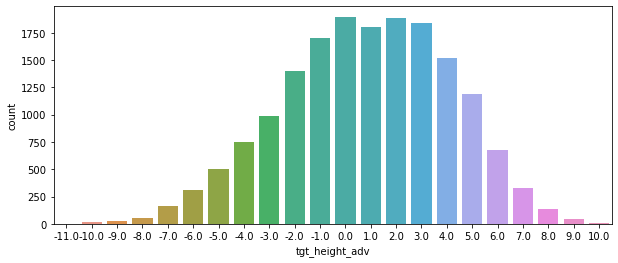

In [29]:
plt.figure(figsize=(10,4))
sns.countplot(data=pass_df, x='tgt_height_adv')
print(pass_df.tgt_height_adv.value_counts().sort_index(ascending=True))

Grouping together the values <= -7 and >= 8 will group the extremes to roughly 200 pass plays.

In [30]:
# group together extreme values
min_bin_bound = -7
max_bin_bound = 8
pass_df['tgt_height_adv_bin'] = pass_df.tgt_height_adv
pass_df.loc[pass_df.tgt_height_adv <= min_bin_bound, 'tgt_height_adv_bin'] = min_bin_bound
pass_df.loc[pass_df.tgt_height_adv >= max_bin_bound, 'tgt_height_adv_bin'] = max_bin_bound

# 3. Calculate passing performance metrics

In [31]:
pass_df = pd.merge(pass_df, play_df,
                  on=['gameId', 'playId'],
                  how='left')

### EPA

<AxesSubplot:xlabel='tgt_height_adv_bin', ylabel='epa'>

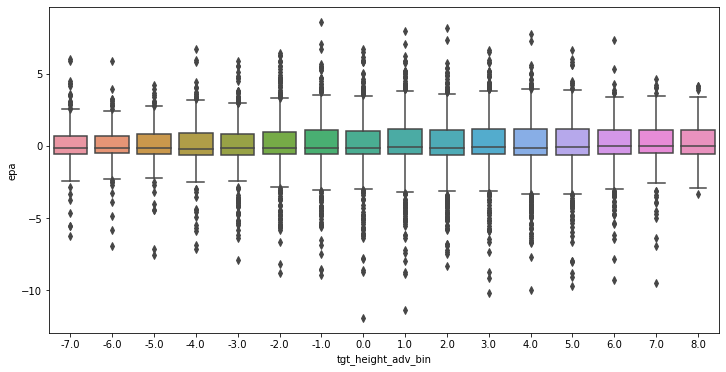

In [32]:
plt.figure(figsize=(12,6))
sns.boxplot(data=pass_df, x='tgt_height_adv_bin', y='epa')

Text(0.5, 0, 'Target Height Advantage (in)')

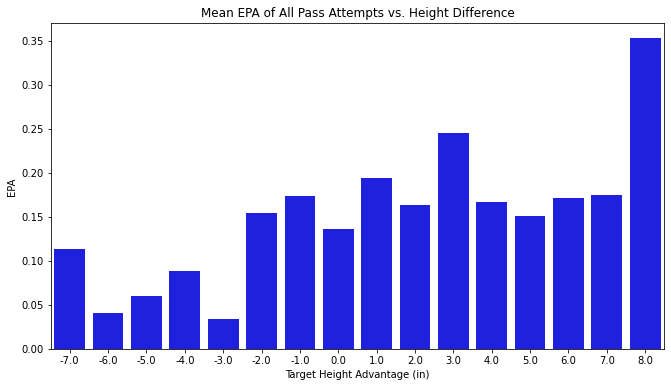

In [33]:
plt.figure(figsize=(11,6))
sns.barplot(data=pass_df, x='tgt_height_adv_bin', y='epa', ci=None, color='b')
plt.title('Mean EPA of All Pass Attempts vs. Height Difference');
plt.ylabel('EPA')
plt.xlabel('Target Height Advantage (in)')

### Completion Percentage

In [34]:
# add column to aid calculating yards per completion
pass_df['yds_cmp'] = np.nan  # NaN for incomplete
pass_df.loc[pass_df.passResult=='C', 'yds_cmp'] = pass_df.loc[pass_df.passResult=='C', 'offensePlayResult']

# compute aggregates
cmp_agg = pass_df[~pass_df.playDescription.str.contains('No Play')].groupby('tgt_height_adv_bin').agg(
    count=pd.NamedAgg(column='playId', aggfunc='count'),
    cmp_pct=pd.NamedAgg(column='passResult', aggfunc=lambda ser: np.sum(ser=='C') / len(ser)),
    yd_per_att=pd.NamedAgg(column='offensePlayResult', aggfunc='mean'),
    yd_per_cmp=pd.NamedAgg(column='yds_cmp', aggfunc=np.nanmean)
).reset_index()
cmp_agg

,tgt_height_adv_bin,count,cmp_pct,yd_per_att,yd_per_cmp
0,-7.0,262,0.816794,7.652672,9.369159
1,-6.0,309,0.805825,6.378641,7.915663
2,-5.0,490,0.740816,6.461224,8.721763
3,-4.0,735,0.725170,6.672109,9.200750
4,-3.0,969,0.705882,6.941176,9.833333
5,-2.0,1367,0.681053,7.517922,11.038668
6,-1.0,1641,0.670932,7.764778,11.573115
7,0.0,1834,0.657579,7.657034,11.644279
8,1.0,1756,0.650342,7.652050,11.766200
9,2.0,1807,0.651356,7.602656,11.672048


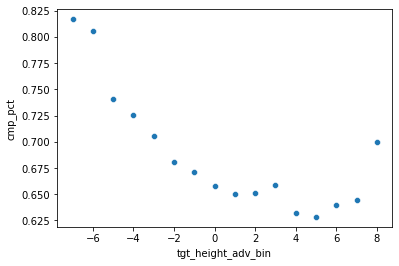

In [35]:
sns.scatterplot(data=cmp_agg, x='tgt_height_adv_bin', y='cmp_pct');

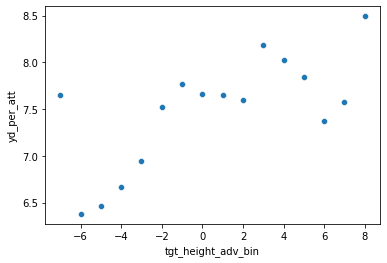

In [36]:
sns.scatterplot(data=cmp_agg, x='tgt_height_adv_bin', y='yd_per_att');

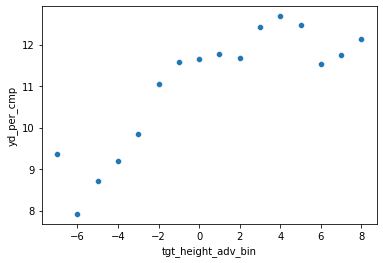

In [37]:
sns.scatterplot(data=cmp_agg, x='tgt_height_adv_bin', y='yd_per_cmp');

This is an interesting trend. Need to group together ends due to low value counts, but this goes against the typical wisdom of height advantage. Need to look to see average depth of pass to see if high mismatch is from short RB/speedsters catching in open space rather than truly beating coverage.

### Depth of pass

In [38]:
# compute aggregates
dop_agg = pass_df[~pass_df.playDescription.str.contains('No Play')].groupby('tgt_height_adv_bin').agg(
    count=pd.NamedAgg(column='playId', aggfunc='count'),
    pass_depth_mean=pd.NamedAgg(column='pass_depth', aggfunc=np.nanmean),
    pass_depth_median=pd.NamedAgg(column='pass_depth', aggfunc=np.nanmedian),
).reset_index()
dop_agg

,tgt_height_adv_bin,count,pass_depth_mean,pass_depth_median
0,-7.0,262,1.051718,0.495
1,-6.0,309,2.292265,1.750
2,-5.0,490,3.515918,2.060
3,-4.0,735,4.459306,2.560
4,-3.0,969,5.620795,3.240
5,-2.0,1367,7.256218,4.570
6,-1.0,1641,8.005369,5.070
7,0.0,1834,8.827028,5.755
8,1.0,1756,9.287460,6.295
9,2.0,1807,9.507720,6.800


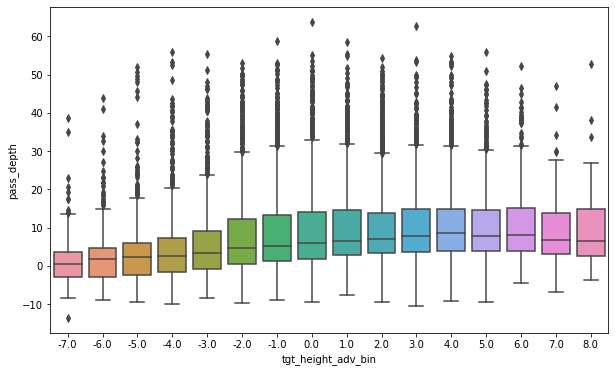

In [39]:
plt.figure(figsize=(10,6))
sns.boxplot(data=pass_df, x='tgt_height_adv_bin', y='pass_depth');

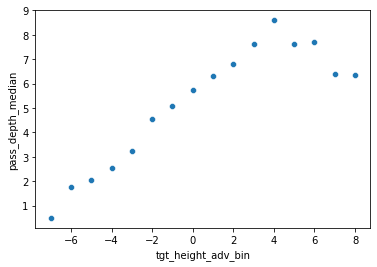

In [40]:
sns.scatterplot(data=dop_agg, x='tgt_height_adv_bin', y='pass_depth_median');

## NEXT UP: Look at completion pctg. vs. depth of pass to determine if there is a height advantage that performs better than expected

# 4. Completion percentage vs. depth of pass

In [41]:
pass_df.columns

Index(['gameId', 'playId', 'nflId_def', 'dist_def', 'pass_depth', 'depth_mean',
       'speed_var', 'off_mean', 'df_rec_space_mean', 'n_deep_frz',
       'dist_shadow_out_play_mean', 'cb_depth_snap_min', 'zone', 'covered',
       'nflId_target', 'def_height', 'tgt_height', 'tgt_height_adv',
       'tgt_height_adv_bin', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI',
       'yds_cmp'],
      dtype='object')

In [42]:
comp_depth_df = pd.merge(closest_def_df[['gameId','playId','pass_depth']],
                         play_df[['gameId','playId','passResult']])
comp_depth_df.dropna(inplace=True)
comp_depth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 0 to 19141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gameId      17277 non-null  int64  
 1   playId      17277 non-null  int64  
 2   pass_depth  17277 non-null  float64
 3   passResult  17277 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 674.9+ KB


In [43]:
comp_depth_df.passResult.value_counts()

C     11276
I      5590
IN      411
Name: passResult, dtype: int64

In [44]:
# add flag for complete vs not complete
comp_depth_df['comp'] = (comp_depth_df.passResult=='C').astype(int)

Look at the distribution of the pass depth looking at multiple bin widths:

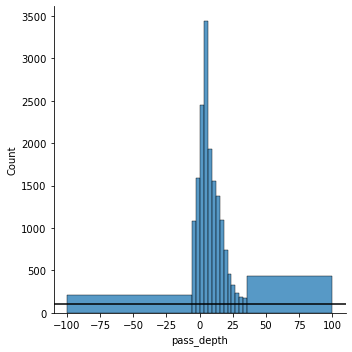

In [45]:
min_depth = -6  # all below this value will be binned together
max_depth = 36 # all above this value will be binned together
bin_width = 3  # yards

depth_bins = np.concatenate([np.array([-100]), np.arange(min_depth, max_depth + 0.01, bin_width), np.array([100])])
# define the depth to use for regression (middle of the bin, except for the ends which will use a cutoff)
depth_points_mid = (depth_bins[1:-2] + depth_bins[2:-1]) / 2
# first and last points are temporary
depth_points = np.concatenate([np.array([-100]), depth_points_mid, np.array([100])])
# set first and last points to the mean value for the extreme bins
depth_points[0] = comp_depth_df.loc[comp_depth_df.pass_depth <= min_depth, 'pass_depth'].mean()
depth_points[-1] = comp_depth_df.loc[comp_depth_df.pass_depth > max_depth, 'pass_depth'].mean()

sns.displot(data=comp_depth_df, x='pass_depth', bins=depth_bins, kind='hist')
plt.axhline(100, color='k')

In [46]:
comp_depth_df['pass_depth_bin'] = pd.cut(comp_depth_df['pass_depth'], depth_bins)

### calculate the completion percentage in each bin

In [47]:
comp_depth_agg = comp_depth_df.groupby('pass_depth_bin').agg(
    comp_pct=pd.NamedAgg(column='comp', aggfunc='mean')
)
comp_depth_agg['depth_point'] = depth_points
comp_depth_agg

,comp_pct,depth_point
pass_depth_bin,,
"(-100.0, -6.0]",0.816038,-7.030755
"(-6.0, -3.0]",0.855433,-4.500000
"(-3.0, 0.0]",0.848332,-1.500000
"(0.0, 3.0]",0.779544,1.500000
"(3.0, 6.0]",0.733817,4.500000
"(6.0, 9.0]",0.666667,7.500000
"(9.0, 12.0]",0.582748,10.500000
"(12.0, 15.0]",0.550073,13.500000
"(15.0, 18.0]",0.513686,16.500000


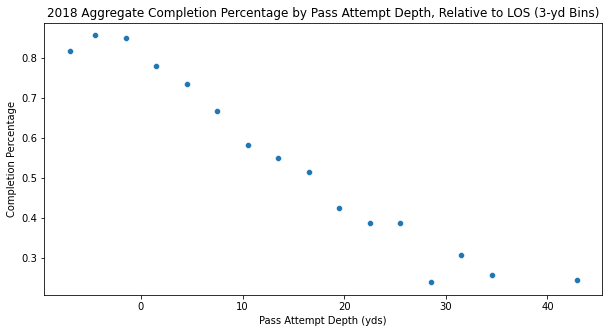

In [48]:
plt.figure(figsize=(10,5))
ax = plt.gcf().gca()
sns.scatterplot(data=comp_depth_agg, x='depth_point', y='comp_pct')
plt.xlabel('Pass Attempt Depth (yds)')
plt.ylabel('Completion Percentage')
plt.title(f'2018 Aggregate Completion Percentage by Pass Attempt Depth, Relative to LOS ({bin_width}-yd Bins)');

Modeling the completion percentage vs. pass attempt depth as a logistic curve (asymptotes at extremes) makes sense: behind line of scrimmage passes are easy, increasing difficulty as depth increases, then reaches a "natural" completion rate when passes are over 35 yards (the marginal difficulty for increasingly long throws is near zero).

In [49]:
def logistic_fcn(depth, a, b, k, q, v):
    return a + (k - a) / ((1 + q * np.exp(-b * depth)) ** (1/v))

In [50]:
# initialize parameters (a,b,k,q,v)
p0 = np.array([.85, .05, .25, .25, 1])
log_bounds = ([0, 0, 0, 0, .00000000001], [1, 3, 1, 1000, 10])

x = comp_depth_agg.depth_point.to_numpy()
y = comp_depth_agg.comp_pct.to_numpy()
cmp_model_params, _ = optim.curve_fit(logistic_fcn, x, y, bounds=log_bounds, p0=p0)
cmp_model_params

array([8.50108319e-01, 9.27869962e-02, 2.01402366e-01, 1.08034847e-04,
       4.09946841e-05])

In [51]:
# create a handle to the completion percentage model
cmp_pct_model = lambda depth: logistic_fcn(depth, *cmp_model_params)

C:\Users\pschl\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


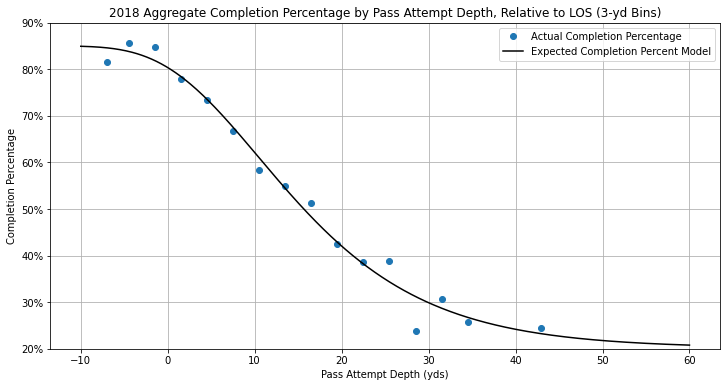

In [52]:
x_curve = np.linspace(-10, 60, 500)
cmp_curve = cmp_pct_model(x_curve)

# plot the data
f = plt.figure(figsize=(12,6))
ax = f.gca()
plt.plot(x, y, marker='o', linestyle='', label='Actual Completion Percentage')
plt.plot(x_curve, cmp_curve, linestyle='-', marker=None, color='k', label='Expected Completion Percent Model')
plt.xlabel('Pass Attempt Depth (yds)')
plt.ylabel('Completion Percentage')
plt.ylim([.2, .9])
# add percentage y-labels
vals = ax.get_yticks()
ax.set_yticklabels([f'{int(i * 100)}%' for i in vals])
plt.title(f'2018 Aggregate Completion Percentage by Pass Attempt Depth, Relative to LOS ({bin_width}-yd Bins)')
plt.legend()
plt.grid(True)

# # plot the data
# f = plt.figure(figsize=(10, 5))
# ax = f.gca()
# plt.plot(x_depth, y_comp_pct, marker='o', linestyle='')
# plt.plot(x_curve, cmp_curve, linestyle='-', marker=None, color='k', label='Expected Completion Percent Model')
# plt.xlabel('Pass Attempt Depth (yds)')
# plt.ylabel('Completion Percentage')
# plt.ylim([.2, .9])
# # add percentage y-labels
# vals = ax.get_yticks()
# ax.set_yticklabels([f'{int(i * 100)}%' for i in vals])
# plt.title(f'2018 Aggregate Completion Percentage by Pass Attempt Depth, Relative to LOS ({bin_width}-yd Bins)')
# plt.legend()
# plt.grid(True)

Look at the residuals:

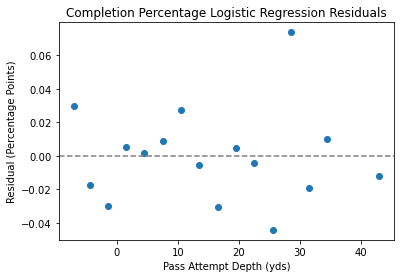

In [53]:
cmp_predict = cmp_pct_model(x)
resid = cmp_predict - y
plt.figure()
plt.plot(x, resid, marker='o', ls='')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('Pass Attempt Depth (yds)')
plt.ylabel('Residual (Percentage Points)')
plt.title('Completion Percentage Logistic Regression Residuals');

The fit is within a few percentage points below 25 yards, which is good enough for a comparative analysis of individual players.

# 5. Compare Cmp Pct Above Average (CPOA) between players

Calculate the completion percentage for each play of the season:

In [54]:
cpoa_df = pass_df[['gameId','playId','nflId_def','pass_depth','zone','covered','passResult','epa']].copy().dropna()
cpoa_df

,gameId,playId,nflId_def,pass_depth,zone,covered,passResult,epa
0,2018090600,75,79848.0,9.00,1.0,1,C,0.261827
1,2018090600,146,2552315.0,4.38,1.0,1,I,-0.372360
2,2018090600,168,2557958.0,-2.85,1.0,1,I,-0.702779
3,2018090600,190,2552689.0,23.14,1.0,1,C,3.047530
4,2018090600,256,2558175.0,2.06,0.0,1,I,-0.842272
...,...,...,...,...,...,...,...,...
19136,2018123014,2170,1302.0,3.84,1.0,1,I,0.848771
19138,2018122200,3177,2558136.0,9.42,0.0,1,I,1.227695
19139,2018122201,566,4365.0,25.73,0.0,1,C,-0.720168
19140,2018122201,1719,2540164.0,16.55,0.0,1,I,1.336078


In [55]:
# calculate the expected completion percentage
cpoa_df['cp_expect'] = cmp_pct_model(cpoa_df.pass_depth)

# remove the plays where there wasn't really coverage (very soft zone)
cpoa_df = cpoa_df[cpoa_df.covered==1]

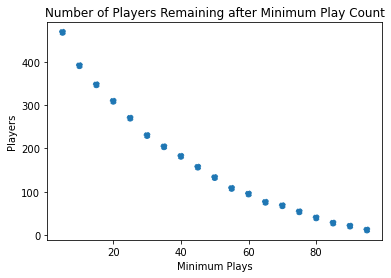

In [56]:
# determine the number of players that would remain if a particular play count is used as a minimum filter
n_plays = cpoa_df.groupby('nflId_def').agg('count')['gameId'].to_numpy()
play_range = np.arange(5,100,5)
n_players = []

for p in play_range:
    n_players.append(np.sum(n_plays >= p))
    
plt.figure()
plt.scatter(play_range, n_players, ls='--', marker='o')
plt.xlabel('Minimum Plays')
plt.ylabel('Players')
plt.title('Number of Players Remaining after Minimum Play Count');

Using 30 as a cutoff is reasonable and leaves over 200 players left to analyze. This also leaves rooms for high-level players that are not target often by design (~2 targets/game).

In [57]:
n_cutoff = 30

# aggregate on defensive players with minimum targets >= n_cutoff
cpoa_df = cpoa_df.groupby('nflId_def').filter(lambda df: len(df) >= n_cutoff)

cpoa_agg = cpoa_df.groupby('nflId_def').agg(
    plays_total = pd.NamedAgg(column='passResult', aggfunc=len),
    plays_zone = pd.NamedAgg(column='zone', aggfunc=lambda x: np.sum(x==1)),
    plays_man = pd.NamedAgg(column='zone', aggfunc=lambda x: np.sum(x==0)),
    epa_avg_tot = pd.NamedAgg(column='epa', aggfunc='mean'),
    cp_tot = pd.NamedAgg(column='passResult', aggfunc=lambda x: np.mean(x=='C')),
    cp_expect_tot = pd.NamedAgg(column='cp_expect', aggfunc='mean'),
).reset_index()

# calculate zone percentage
cpoa_agg['pct_zone'] = cpoa_agg.plays_zone / cpoa_agg.plays_total

# make play count columns integers
cpoa_agg['plays_zone'] = cpoa_agg.plays_zone.astype(int)
cpoa_agg['plays_man'] = cpoa_agg.plays_man.astype(int)

# calculate CPOA
cpoa_agg['cpoa'] = cpoa_agg.cp_expect_tot - cpoa_agg.cp_tot

cpoa_agg = pd.merge(cpoa_agg, player_df[['nflId','displayName','position']], 
                   left_on='nflId_def', right_on='nflId', how='left').drop(columns='nflId')
cpoa_agg

,nflId_def,plays_total,plays_zone,plays_man,epa_avg_tot,cp_tot,cp_expect_tot,pct_zone,cpoa,displayName,position
0,1302.0,32,26,6,-0.153268,0.562500,0.619172,0.812500,0.056672,Aqib Talib,CB
1,2307.0,92,42,50,0.117970,0.489130,0.590640,0.456522,0.101510,Orlando Scandrick,CB
2,2354.0,41,27,14,0.235107,0.707317,0.695256,0.658537,-0.012061,Wesley Woodyard,ILB
3,4365.0,86,50,36,0.123531,0.500000,0.577517,0.581395,0.077517,Brandon Carr,CB
4,71251.0,77,38,39,-0.037998,0.636364,0.658328,0.493506,0.021964,Patrick Chung,SS
...,...,...,...,...,...,...,...,...,...,...,...
225,2560982.0,40,26,14,0.349700,0.600000,0.616400,0.650000,0.016400,Tony Brown,CB
226,2561001.0,34,22,12,0.440803,0.764706,0.694115,0.647059,-0.070591,Grant Haley,CB
227,2561039.0,61,35,26,0.313815,0.540984,0.587194,0.573770,0.046211,Carlton Davis,CB
228,2561132.0,47,38,9,0.174755,0.808511,0.684445,0.808511,-0.124066,Foye Oluokun,LB


In [58]:
# get the average EPA for zone vs. man coverage
epa_agg = cpoa_df.groupby(['nflId_def', 'zone']).agg(
    epa_avg = pd.NamedAgg(column='epa', aggfunc='mean'),
    cp_avg = pd.NamedAgg(column='passResult', aggfunc=lambda x: np.mean(x=='C')),
    cp_expect_avg = pd.NamedAgg(column='cp_expect', aggfunc='mean'),
).unstack()
epa_agg.columns=['epa_avg_man', 'epa_avg_zone', 'cp_man', 'cp_zone', 'cp_expect_man', 'cp_expect_zone']
epa_agg.reset_index(inplace=True)

# calculate cpoa
epa_agg['cpoa_man'] = epa_agg.cp_expect_man - epa_agg.cp_man
epa_agg['cpoa_zone'] = epa_agg.cp_expect_zone - epa_agg.cp_zone

# show
epa_agg

,nflId_def,epa_avg_man,epa_avg_zone,cp_man,cp_zone,cp_expect_man,cp_expect_zone,cpoa_man,cpoa_zone
0,1302.0,1.286645,-0.485556,1.000000,0.461538,0.603536,0.622780,-0.396464,0.161242
1,2307.0,0.349088,-0.157171,0.560000,0.404762,0.594203,0.586399,0.034203,0.181637
2,2354.0,-0.139554,0.429376,0.428571,0.851852,0.747590,0.668119,0.319019,-0.183733
3,4365.0,0.275152,0.014363,0.500000,0.500000,0.562615,0.588246,0.062615,0.088246
4,71251.0,0.203612,-0.285966,0.564103,0.710526,0.618889,0.698804,0.054786,-0.011722
...,...,...,...,...,...,...,...,...,...
225,2560982.0,0.386753,0.329748,0.571429,0.615385,0.612331,0.618590,0.040903,0.003206
226,2561001.0,0.399214,0.463488,0.833333,0.727273,0.671235,0.706595,-0.162098,-0.020678
227,2561039.0,0.479134,0.191006,0.461538,0.600000,0.556586,0.609932,0.095047,0.009932
228,2561132.0,0.753582,0.037664,0.888889,0.789474,0.657973,0.690714,-0.230916,-0.098759


In [59]:
# add EPA breakdown into cpoa dataframe
cpoa_agg = pd.merge(cpoa_agg, epa_agg, on='nflId_def')
cpoa_agg

,nflId_def,plays_total,plays_zone,plays_man,epa_avg_tot,cp_tot,cp_expect_tot,pct_zone,cpoa,displayName,position,epa_avg_man,epa_avg_zone,cp_man,cp_zone,cp_expect_man,cp_expect_zone,cpoa_man,cpoa_zone
0,1302.0,32,26,6,-0.153268,0.562500,0.619172,0.812500,0.056672,Aqib Talib,CB,1.286645,-0.485556,1.000000,0.461538,0.603536,0.622780,-0.396464,0.161242
1,2307.0,92,42,50,0.117970,0.489130,0.590640,0.456522,0.101510,Orlando Scandrick,CB,0.349088,-0.157171,0.560000,0.404762,0.594203,0.586399,0.034203,0.181637
2,2354.0,41,27,14,0.235107,0.707317,0.695256,0.658537,-0.012061,Wesley Woodyard,ILB,-0.139554,0.429376,0.428571,0.851852,0.747590,0.668119,0.319019,-0.183733
3,4365.0,86,50,36,0.123531,0.500000,0.577517,0.581395,0.077517,Brandon Carr,CB,0.275152,0.014363,0.500000,0.500000,0.562615,0.588246,0.062615,0.088246
4,71251.0,77,38,39,-0.037998,0.636364,0.658328,0.493506,0.021964,Patrick Chung,SS,0.203612,-0.285966,0.564103,0.710526,0.618889,0.698804,0.054786,-0.011722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2560982.0,40,26,14,0.349700,0.600000,0.616400,0.650000,0.016400,Tony Brown,CB,0.386753,0.329748,0.571429,0.615385,0.612331,0.618590,0.040903,0.003206
226,2561001.0,34,22,12,0.440803,0.764706,0.694115,0.647059,-0.070591,Grant Haley,CB,0.399214,0.463488,0.833333,0.727273,0.671235,0.706595,-0.162098,-0.020678
227,2561039.0,61,35,26,0.313815,0.540984,0.587194,0.573770,0.046211,Carlton Davis,CB,0.479134,0.191006,0.461538,0.600000,0.556586,0.609932,0.095047,0.009932
228,2561132.0,47,38,9,0.174755,0.808511,0.684445,0.808511,-0.124066,Foye Oluokun,LB,0.753582,0.037664,0.888889,0.789474,0.657973,0.690714,-0.230916,-0.098759


In [60]:
# cpoa_agg[cpoa_agg.position.isin(['CB','DB'])].sort_values('cpoa', ascending=False).head(15)
cpoa_agg[cpoa_agg.position.isin(['CB','DB'])].sort_values('cpoa', ascending=False).head(15)

,nflId_def,plays_total,plays_zone,plays_man,epa_avg_tot,cp_tot,cp_expect_tot,pct_zone,cpoa,displayName,position,epa_avg_man,epa_avg_zone,cp_man,cp_zone,cp_expect_man,cp_expect_zone,cpoa_man,cpoa_zone
180,2558067.0,81,45,36,-0.319820,0.456790,0.601196,0.555556,0.144406,Marlon Humphrey,CB,-0.218949,-0.400517,0.416667,0.488889,0.574339,0.622682,0.157672,0.133793
27,2506789.0,51,30,21,-0.057102,0.509804,0.633697,0.588235,0.123893,Tramon Williams,CB,-0.298079,0.111583,0.380952,0.600000,0.613624,0.647747,0.232672,0.047747
217,2560916.0,86,37,49,0.006818,0.500000,0.619308,0.430233,0.119308,Denzel Ward,CB,-0.114948,0.168076,0.367347,0.675676,0.583189,0.667140,0.215842,-0.008535
54,2533060.0,71,40,31,0.231331,0.450704,0.555999,0.563380,0.105294,Dre Kirkpatrick,CB,0.354137,0.136156,0.451613,0.450000,0.514340,0.588284,0.062727,0.138284
166,2557867.0,72,44,28,0.099091,0.527778,0.632156,0.611111,0.104378,Tre'Davious White,CB,-0.033355,0.183375,0.500000,0.545455,0.605851,0.648895,0.105851,0.103440
55,2533062.0,96,38,58,-0.260078,0.437500,0.540866,0.395833,0.103366,Stephon Gilmore,CB,-0.353422,-0.117608,0.396552,0.500000,0.560145,0.511441,0.163593,0.011441
1,2307.0,92,42,50,0.117970,0.489130,0.590640,0.456522,0.101510,Orlando Scandrick,CB,0.349088,-0.157171,0.560000,0.404762,0.594203,0.586399,0.034203,0.181637
30,2507917.0,44,24,20,0.089378,0.500000,0.598622,0.545455,0.098622,Tramaine Brock,CB,0.137718,0.049096,0.400000,0.583333,0.560789,0.630150,0.160789,0.046817
186,2558157.0,75,43,32,0.176667,0.480000,0.577963,0.573333,0.097963,Ahkello Witherspoon,CB,0.655994,-0.180042,0.500000,0.465116,0.562179,0.589710,0.062179,0.124594
90,2543637.0,52,27,25,0.168222,0.538462,0.633546,0.519231,0.095084,Terrance Mitchell,CB,0.386375,-0.033771,0.480000,0.592593,0.633784,0.633325,0.153784,0.040733


In [61]:
cpoa_agg[cpoa_agg.position.isin(['CB','DB'])].sort_values('cpoa', ascending=False).head(15)
# cpoa_agg[cpoa_agg.position.isin(['CB','DB'])].cpoa_man.plot.box()
# cpoa_agg.cpoa_zone.describe()

,nflId_def,plays_total,plays_zone,plays_man,epa_avg_tot,cp_tot,cp_expect_tot,pct_zone,cpoa,displayName,position,epa_avg_man,epa_avg_zone,cp_man,cp_zone,cp_expect_man,cp_expect_zone,cpoa_man,cpoa_zone
180,2558067.0,81,45,36,-0.319820,0.456790,0.601196,0.555556,0.144406,Marlon Humphrey,CB,-0.218949,-0.400517,0.416667,0.488889,0.574339,0.622682,0.157672,0.133793
27,2506789.0,51,30,21,-0.057102,0.509804,0.633697,0.588235,0.123893,Tramon Williams,CB,-0.298079,0.111583,0.380952,0.600000,0.613624,0.647747,0.232672,0.047747
217,2560916.0,86,37,49,0.006818,0.500000,0.619308,0.430233,0.119308,Denzel Ward,CB,-0.114948,0.168076,0.367347,0.675676,0.583189,0.667140,0.215842,-0.008535
54,2533060.0,71,40,31,0.231331,0.450704,0.555999,0.563380,0.105294,Dre Kirkpatrick,CB,0.354137,0.136156,0.451613,0.450000,0.514340,0.588284,0.062727,0.138284
166,2557867.0,72,44,28,0.099091,0.527778,0.632156,0.611111,0.104378,Tre'Davious White,CB,-0.033355,0.183375,0.500000,0.545455,0.605851,0.648895,0.105851,0.103440
55,2533062.0,96,38,58,-0.260078,0.437500,0.540866,0.395833,0.103366,Stephon Gilmore,CB,-0.353422,-0.117608,0.396552,0.500000,0.560145,0.511441,0.163593,0.011441
1,2307.0,92,42,50,0.117970,0.489130,0.590640,0.456522,0.101510,Orlando Scandrick,CB,0.349088,-0.157171,0.560000,0.404762,0.594203,0.586399,0.034203,0.181637
30,2507917.0,44,24,20,0.089378,0.500000,0.598622,0.545455,0.098622,Tramaine Brock,CB,0.137718,0.049096,0.400000,0.583333,0.560789,0.630150,0.160789,0.046817
186,2558157.0,75,43,32,0.176667,0.480000,0.577963,0.573333,0.097963,Ahkello Witherspoon,CB,0.655994,-0.180042,0.500000,0.465116,0.562179,0.589710,0.062179,0.124594
90,2543637.0,52,27,25,0.168222,0.538462,0.633546,0.519231,0.095084,Terrance Mitchell,CB,0.386375,-0.033771,0.480000,0.592593,0.633784,0.633325,0.153784,0.040733


In [62]:
cpoa_agg[['plays_zone','plays_man']].describe()

,plays_zone,plays_man
count,230.000000,230.000000
mean,38.873913,19.117391
std,14.175652,11.990504
min,12.000000,1.000000
25%,28.000000,11.000000
50%,37.000000,16.000000
75%,45.000000,24.000000
max,91.000000,62.000000


In [63]:
cpoa_agg.sort_values('plays_man', ascending=False)

,nflId_def,plays_total,plays_zone,plays_man,epa_avg_tot,cp_tot,cp_expect_tot,pct_zone,cpoa,displayName,position,epa_avg_man,epa_avg_zone,cp_man,cp_zone,cp_expect_man,cp_expect_zone,cpoa_man,cpoa_zone
179,2558065.0,107,45,62,0.159927,0.588785,0.588881,0.420561,0.000096,Adoree' Jackson,CB,0.504138,-0.314319,0.629032,0.533333,0.575315,0.607571,-0.053717,0.074238
55,2533062.0,96,38,58,-0.260078,0.437500,0.540866,0.395833,0.103366,Stephon Gilmore,CB,-0.353422,-0.117608,0.396552,0.500000,0.560145,0.511441,0.163593,0.011441
8,89756.0,82,24,58,0.030416,0.548780,0.583735,0.292683,0.034954,Jason McCourty,CB,-0.071022,0.275560,0.500000,0.666667,0.576450,0.601339,0.076450,-0.065328
137,2555277.0,120,62,58,0.124827,0.533333,0.578276,0.516667,0.044942,Eli Apple,CB,0.269691,-0.010692,0.465517,0.596774,0.557770,0.597458,0.092253,0.000684
77,2540288.0,94,41,53,0.005989,0.468085,0.540020,0.436170,0.071935,Darius Slay,CB,0.185831,-0.226490,0.490566,0.439024,0.575956,0.493566,0.085390,0.054542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,2552592.0,31,27,4,0.352451,0.903226,0.734735,0.870968,-0.168491,Kwon Alexander,MLB,0.363934,0.350750,1.000000,0.888889,0.806153,0.724154,-0.193847,-0.164735
9,494259.0,34,30,4,0.719136,0.588235,0.603084,0.882353,0.014849,Barry Church,SS,1.588596,0.603208,1.000000,0.533333,0.685356,0.592115,-0.314644,0.058782
141,2555329.0,43,40,3,-0.050161,0.720930,0.739761,0.930233,0.018831,Myles Jack,OLB,-1.114251,0.029646,1.000000,0.700000,0.784477,0.736407,-0.215523,0.036407
112,2552386.0,41,39,2,0.099984,0.731707,0.686680,0.951220,-0.045027,Clayton Geathers,FS,-0.477715,0.129609,1.000000,0.717949,0.828033,0.679431,-0.171967,-0.038517


### Plots for CB/DB

In [64]:
# reduced dataframe
cb_agg = cpoa_agg[cpoa_agg.position.isin(['CB','DB'])].copy()

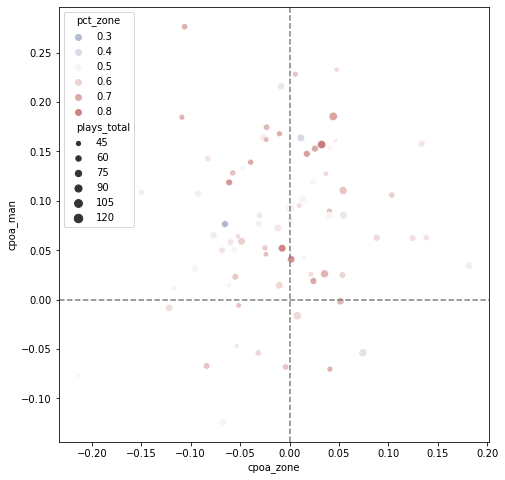

In [65]:
# plot CPOA man and zone
cb_mz = cb_agg[(cb_agg.plays_zone >= 20) & (cb_agg.plays_man >= 20)]
plt.figure(figsize=(8,8))
sns.scatterplot(data=cb_mz, x='cpoa_zone', y='cpoa_man', size='plays_total', hue='pct_zone', hue_norm=(0,1),
               palette="vlag", edgecolors='k')
plt.axhline(0, ls='--', c='gray')
plt.axvline(0, ls='--', c='gray')
plt.gca().set_aspect('equal')

C:\Users\pschl\anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pschl\anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator


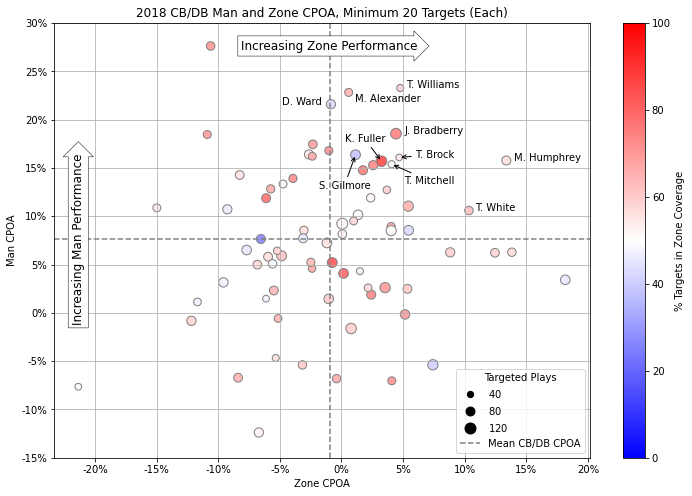

In [136]:
# plot CPOA man and zone
cb_mz = cb_agg[(cb_agg.plays_zone >= 20) & (cb_agg.plays_man >= 20)].copy()
# plt.figure(figsize=(8,8))
# sns.scatterplot(data=cb_mz, x='cpoa_zone', y='cpoa_man', size='plays_total', hue='pct_zone', hue_norm=(0,1),
#                palette="vlag", edgecolors='k')


# figure
f=plt.figure(figsize=(12,8))
ax=f.gca()
plt.axhline(cb_mz.cpoa_man.mean(), ls='--', c='gray')
plt.axvline(cb_mz.cpoa_zone.mean(), ls='--', c='gray')
scatter = plt.scatter(cb_mz.cpoa_zone, cb_mz.cpoa_man,
                      c=cb_mz.pct_zone*100,
                      s=cb_mz.plays_total,
                      marker='o',
                      edgecolors='gray',
                      cmap='bwr')
# plt.gca().set_aspect('equal')
plt.grid(True)

# colorbar
plt.colorbar(label='% Targets in Zone Coverage', orientation='vertical')
plt.clim([0, 100])

# legend
sizes=[40, 80, 120]
scatter_legend = plt.scatter([None]*len(sizes), [None]*len(sizes), s=sizes, c='k')
mean_legend = plt.plot([], [], ls='--', c='gray', label='Mean CPOA')[0]
legend_elements = scatter_legend.legend_elements(prop='sizes')
legend_elements[0].append(mean_legend)
legend_elements[1].append("Mean CB/DB CPOA")
plt.legend(*legend_elements, title='Targeted Plays', loc='lower right');

# limits
ax.set_ylim([-.15, .30])

### annotations
# arrows
ax.text(cb_mz.cpoa_zone.mean(), cb_mz.cpoa_man.max(),
        "Increasing Zone Performance", ha="center", va="center", rotation=0, size=12,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec=[.05, .05, .05], lw=0.5))

ax.text(cb_mz.cpoa_zone.min(), cb_mz.cpoa_man.mean(),
        "Increasing Man Performance", ha="center", va="center", rotation=90, size=12,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec=[.05, .05, .05], lw=0.5))

# players
temp_df = cb_mz.copy()
temp_df['cpoa_dist'] = np.sqrt(((cb_mz.cpoa_zone - cb_mz.cpoa_zone.mean()) / cb_mz.cpoa_zone.std())**2 
                             + ((cb_mz.cpoa_man - cb_mz.cpoa_man.mean()) / cb_mz.cpoa_man.std())**2)
temp_df['shortName'] = temp_df.displayName.str.split().apply(lambda x: x[0][0] + '. ' + x[1])
# get top 10 performers
temp_df = temp_df[(temp_df.cpoa_zone > temp_df.cpoa_zone.mean()) 
        & (temp_df.cpoa_man > temp_df.cpoa_man.mean())].sort_values('cpoa_dist', ascending=False).head(10).set_index('displayName')
annot_df = pd.DataFrame({'x_offset': 0, 'y_offset': 0, 'arrowstyle': None}, index=temp_df.index)
annot_df.loc['Denzel Ward',:] = [-0.04, 0, None]
annot_df.loc['Mackensie Alexander',:] = [0.005, -0.01, None]
annot_df.loc['Tramon Williams',:] = [0.005, 0, None]
annot_df.loc['James Bradberry',:] = [0.007, 0, None]
annot_df.loc['Stephon Gilmore',:] = [-0.03, -0.035, '->']
annot_df.loc['Marlon Humphrey',:] = [0.006, 0, None]
annot_df.loc["Tre'Davious White",:] = [0.005, 0, None]
annot_df.loc['Tramaine Brock',:] = [0.013, 0, '->']
annot_df.loc['Kyle Fuller',:] = [-0.03, 0.02, '->']
annot_df.loc['Terrance Mitchell',:] = [0.01, -0.02, '->']

for name, row in temp_df.iterrows():
    if annot_df.loc[name].arrowstyle is not None:
        annot_kwarg = {'arrowprops': {'arrowstyle': annot_df.loc[name].arrowstyle}}
    else:
        annot_kwarg = {}
        
    ax.annotate(row.shortName, (row.cpoa_zone, row.cpoa_man), 
                xytext=(row.cpoa_zone + annot_df.loc[name].x_offset, row.cpoa_man + annot_df.loc[name].y_offset),
#                 xytext=(row.cpoa_zone, row.cpoa_man),
                **annot_kwarg)

# make axis labels percentages
x_vals = ax.get_xticks()
ax.set_xticklabels([f'{round(i*100)}%' for i in x_vals])
y_vals = ax.get_yticks()
ax.set_yticklabels([f'{round(i*100)}%' for i in y_vals])

# labels and title
plt.xlabel('Zone CPOA')
plt.ylabel('Man CPOA')
plt.title('2018 CB/DB Man and Zone CPOA, Minimum 20 Targets (Each)');

In [67]:
cb_mz['cpoa_dist'] = np.sqrt(((cb_mz.cpoa_zone - cb_mz.cpoa_zone.mean()) / cb_mz.cpoa_zone.std())**2 
                             + ((cb_mz.cpoa_man - cb_mz.cpoa_man.mean()) / cb_mz.cpoa_man.std())**2)

cols=['displayName','plays_total','cpoa_dist','epa_avg_tot','pct_zone','cp_man','cp_zone','cp_expect_man','cp_expect_zone','cpoa_man','cpoa_zone']
cb_mz[(cb_mz.cpoa_zone > cb_mz.cpoa_zone.mean()) & (cb_mz.cpoa_man > cb_mz.cpoa_man.mean())][cols].sort_values('cpoa_dist', ascending=False).reset_index(drop=True)

,displayName,plays_total,cpoa_dist,epa_avg_tot,pct_zone,cp_man,cp_zone,cp_expect_man,cp_expect_zone,cpoa_man,cpoa_zone
0,Marlon Humphrey,81,2.326257,-0.319820,0.555556,0.416667,0.488889,0.574339,0.622682,0.157672,0.133793
1,Tramon Williams,51,2.116942,-0.057102,0.588235,0.380952,0.600000,0.613624,0.647747,0.232672,0.047747
2,Mackensie Alexander,65,1.900781,-0.186343,0.630769,0.416667,0.731707,0.644788,0.737614,0.228121,0.005907
3,Denzel Ward,86,1.734162,0.006818,0.430233,0.367347,0.675676,0.583189,0.667140,0.215842,-0.008535
4,Tre'Davious White,72,1.691500,0.099091,0.611111,0.500000,0.545455,0.605851,0.648895,0.105851,0.103440
5,James Bradberry,114,1.566192,-0.001006,0.719298,0.406250,0.512195,0.591677,0.556424,0.185427,0.044229
6,Tramaine Brock,44,1.332474,0.089378,0.545455,0.400000,0.583333,0.560789,0.630150,0.160789,0.046817
7,Terrance Mitchell,52,1.208843,0.168222,0.519231,0.480000,0.592593,0.633784,0.633325,0.153784,0.040733
8,Kyle Fuller,111,1.173007,-0.164655,0.819820,0.400000,0.582418,0.556935,0.614928,0.156935,0.032511
9,Stephon Gilmore,96,1.124653,-0.260078,0.395833,0.396552,0.500000,0.560145,0.511441,0.163593,0.011441


### CB/DB CPOA vs. EPA

In [68]:
def plot_cpoa_vs_epa(agg_df, positions, play_thresh=30, show_cpoa_mean=True,
                     alt_cpoa_metric=None,
                     alt_epa_metric=None,
                     show_zone_pct_split=False,
                     show_short_names=False,
                     figsize=(12,8)):
    # only work with copy of the dataframe
    df = agg_df.copy()
    
    # add short names (F. Last) to dataframe
    df['shortName'] = df.displayName.str.split().apply(lambda x: x[0][0] + '. ' + x[1])
    
    # get entries for given position (either list or str)
    if type(positions) is str:
        df = df[df.position == positions]
    elif type(positions) is list or type(positions) is tuple:
        df = df[df.position.isin(positions)]
    else:
        raise TypeError("'positions' input must be str, list, or tuple")
    
    # filter by minimum total plays
    df = df[df.plays_total >= play_thresh]
    
    ####### plot
    
    # figure
    f=plt.figure(figsize=figsize)
    ax=f.gca()
    
    if show_cpoa_mean:
        plt.axhline(df.cpoa.mean(), ls='--', c='gray')
    
    # EPA = 0 line
    plt.axvline(0, ls='-', c='black', linewidth=2)
    
    color_kwargs = {}
    if show_zone_pct_split:
        color_kwargs['c'] = df.pct_zone*100
        color_kwargs['cmap'] = 'bwr'
        
    if alt_cpoa_metric is not None:
        cpoa = df[alt_cpoa_metric]
    else:
        cpoa = df.cpoa
        
    if alt_epa_metric is not None:
        epa = df[alt_epa_metric]
    else:
        epa = df.epa_avg_tot
    
    scatter = plt.scatter(-epa,
                          cpoa,
                          s=df.plays_total,
                          marker='o',
                          edgecolors='gray',
                          **color_kwargs)
    # plt.gca().set_aspect('equal')
    plt.grid(True)
    
    # player labels
    if show_short_names:
        for idx, row in df.iterrows():
            ax.annotate(row.shortName, (-epa[idx], cpoa[idx]), 
    #                     xytext=(row.cpoa_zone + annot_df.loc[name].x_offset, row.cpoa_man + annot_df.loc[name].y_offset),
#                         xytext=(row.cpoa_zone, row.cpoa_man)
                        )
    
    # axis labels
    plt.xlabel('Average Expected Points Mitigated (-EPA of Offense)')
    plt.ylabel('CPOA')

    # add zone percentage colorbar (if show_zone_pct_split = True)
    if show_zone_pct_split:
        plt.colorbar(label='% Targets in Zone Coverage', orientation='vertical')
        plt.clim([0, 100])

    # legend
    sizes=[20, 40, 80, 120]
    scatter_legend = plt.scatter([None]*len(sizes), [None]*len(sizes), s=sizes, c='k')
    legend_elements = scatter_legend.legend_elements(prop='sizes')
    
    if show_cpoa_mean:
        mean_legend = plt.plot([], [], ls='--', c='gray', label='Mean CPOA')[0]
        legend_elements[0].append(mean_legend)
        legend_elements[1].append("Mean CPOA")
        
    plt.legend(*legend_elements, title='Targeted Plays', loc='lower right');

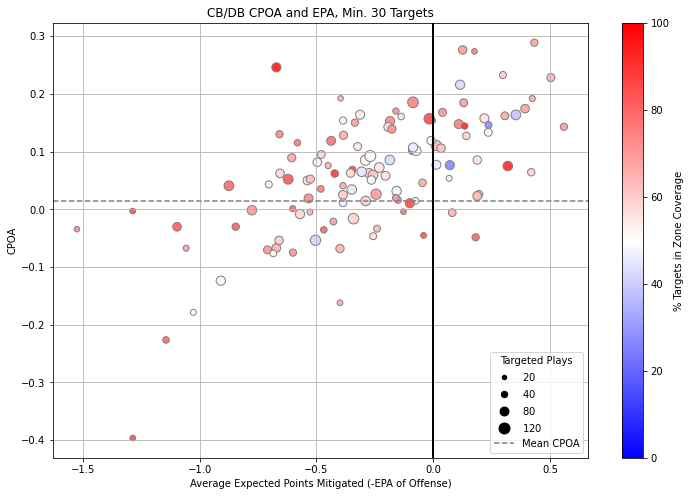

In [69]:
positions = ['CB', 'DB']
play_thresh=30
show_cpoa_mean=True
show_zone_pct_split=True
# alt_cpoa_metric=None
# alt_cpoa_metric='cpoa_zone'
# alt_epa_metric='epa_avg_zone'
alt_cpoa_metric='cpoa_man'
alt_epa_metric='epa_avg_man'

plot_cpoa_vs_epa(cpoa_agg, positions, play_thresh=play_thresh, 
                 show_cpoa_mean=show_cpoa_mean, 
                 show_zone_pct_split=show_zone_pct_split,
                 alt_cpoa_metric=alt_cpoa_metric,
                 alt_epa_metric=alt_epa_metric,
                 )
plt.title('CB/DB CPOA and EPA, Min. 30 Targets');

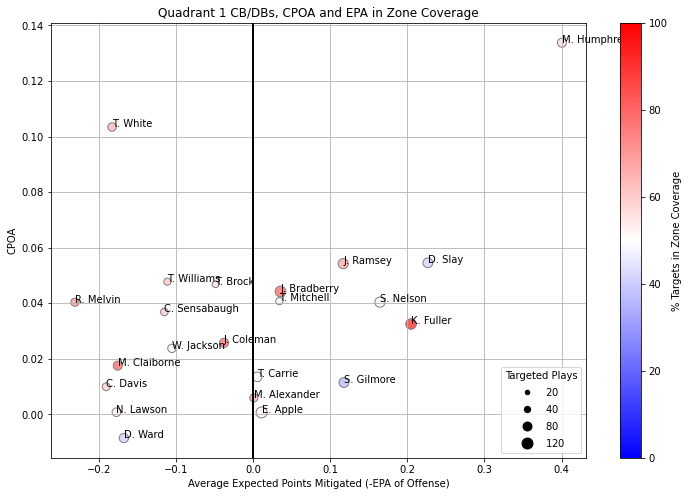

In [70]:
top_cb = cb_mz[(cb_mz.cpoa_zone > cb_mz.cpoa_zone.mean()) & (cb_mz.cpoa_man > cb_mz.cpoa_man.mean())]

positions = ['CB', 'DB']
play_thresh=40
show_cpoa_mean=False
show_zone_pct_split=True
# alt_cpoa_metric=None
alt_cpoa_metric='cpoa_zone'
alt_epa_metric='epa_avg_zone'
# alt_cpoa_metric='cpoa_man'
# alt_epa_metric='epa_avg_man'
show_names=True

plot_cpoa_vs_epa(top_cb, positions, play_thresh=play_thresh, 
                 show_cpoa_mean=show_cpoa_mean, 
                 show_zone_pct_split=show_zone_pct_split,
                 alt_cpoa_metric=alt_cpoa_metric,
                 alt_epa_metric=alt_epa_metric,
                 show_short_names=show_names)
plt.title('Quadrant 1 CB/DBs, CPOA and EPA in Zone Coverage');

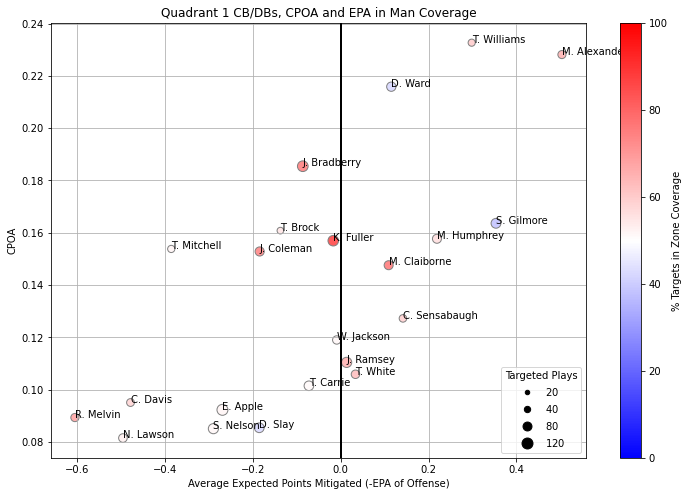

In [71]:
top_cb = cb_mz[(cb_mz.cpoa_zone > cb_mz.cpoa_zone.mean()) & (cb_mz.cpoa_man > cb_mz.cpoa_man.mean())]

positions = ['CB', 'DB']
play_thresh=40
show_cpoa_mean=False
show_zone_pct_split=True
# alt_cpoa_metric=None
# alt_cpoa_metric='cpoa_zone'
# alt_epa_metric='epa_avg_zone'
alt_cpoa_metric='cpoa_man'
alt_epa_metric='epa_avg_man'
show_names=True

plot_cpoa_vs_epa(top_cb, positions, play_thresh=play_thresh, 
                 show_cpoa_mean=show_cpoa_mean, 
                 show_zone_pct_split=show_zone_pct_split,
                 alt_cpoa_metric=alt_cpoa_metric,
                 alt_epa_metric=alt_epa_metric,
                 show_short_names=show_names)
plt.title('Quadrant 1 CB/DBs, CPOA and EPA in Man Coverage');

In [72]:
top_cb[(top_cb.epa_avg_man <= 0) & (top_cb.epa_avg_zone <= 0)]

,nflId_def,plays_total,plays_zone,plays_man,epa_avg_tot,cp_tot,cp_expect_tot,pct_zone,cpoa,displayName,position,epa_avg_man,epa_avg_zone,cp_man,cp_zone,cp_expect_man,cp_expect_zone,cpoa_man,cpoa_zone,cpoa_dist
55,2533062.0,96,38,58,-0.260078,0.437500,0.540866,0.395833,0.103366,Stephon Gilmore,CB,-0.353422,-0.117608,0.396552,0.500000,0.560145,0.511441,0.163593,0.011441,1.124653
135,2555177.0,65,41,24,-0.186343,0.615385,0.703340,0.630769,0.087955,Mackensie Alexander,CB,-0.503614,-0.000624,0.416667,0.731707,0.644788,0.737614,0.228121,0.005907,1.900781
138,2555280.0,104,66,38,-0.078864,0.500000,0.574760,0.634615,0.074760,Jalen Ramsey,CB,-0.013204,-0.116669,0.447368,0.530303,0.557765,0.584545,0.110397,0.054242,1.022195
180,2558067.0,81,45,36,-0.319820,0.456790,0.601196,0.555556,0.144406,Marlon Humphrey,CB,-0.218949,-0.400517,0.416667,0.488889,0.574339,0.622682,0.157672,0.133793,2.326257


## LB

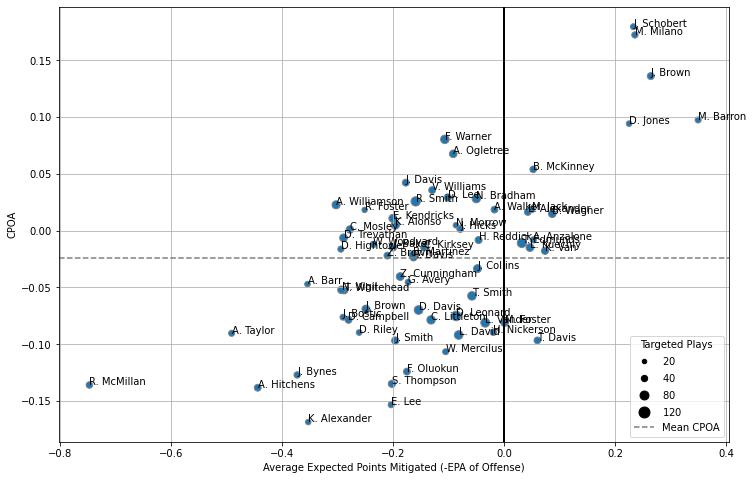

In [73]:
positions = ['LB', 'OLB', 'MLB', 'ILB']
play_thresh=30
show_cpoa_mean=True
show_zone_pct_split=False
alt_cpoa_metric=None
alt_epa_metric=None
# alt_cpoa_metric='cpoa_zone'
# alt_epa_metric='epa_avg_zone'
# alt_cpoa_metric='cpoa_man'
# alt_epa_metric='epa_avg_man'
show_names=True

plot_cpoa_vs_epa(cpoa_agg, positions, play_thresh=play_thresh, 
                 show_cpoa_mean=show_cpoa_mean, 
                 show_zone_pct_split=show_zone_pct_split,
                 alt_cpoa_metric=alt_cpoa_metric,
                 alt_epa_metric=alt_epa_metric,
                 show_short_names=show_names)

## Safety

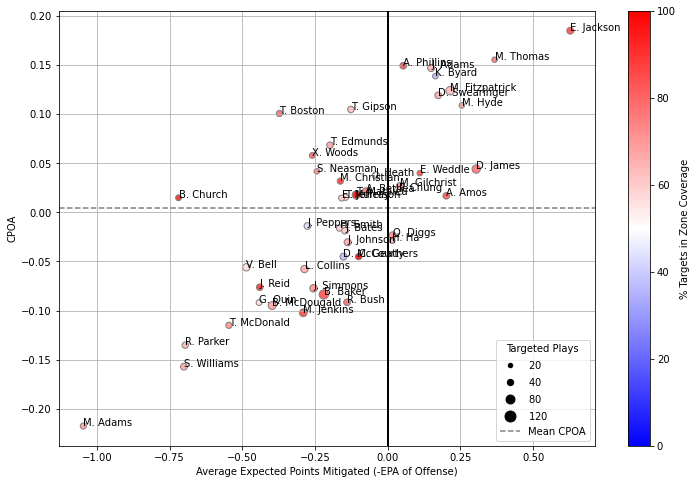

In [74]:
positions = ['S', 'FS', 'SS']
play_thresh=30
show_cpoa_mean=True
show_zone_pct_split=True
alt_cpoa_metric=None
alt_epa_metric=None
# alt_cpoa_metric='cpoa_zone'
# alt_epa_metric='epa_avg_zone'
# alt_cpoa_metric='cpoa_man'
# alt_epa_metric='epa_avg_man'
show_names=True

plot_cpoa_vs_epa(cpoa_agg, positions, play_thresh=play_thresh, 
                 show_cpoa_mean=show_cpoa_mean, 
                 show_zone_pct_split=show_zone_pct_split,
                 alt_cpoa_metric=alt_cpoa_metric,
                 alt_epa_metric=alt_epa_metric,
                 show_short_names=True)

# Team plays man/zone percentage

In [75]:
cpoa_df

,gameId,playId,nflId_def,pass_depth,zone,covered,passResult,epa,cp_expect
0,2018090600,75,79848.0,9.00,1.0,1,C,0.261827,0.643320
1,2018090600,146,2552315.0,4.38,1.0,1,I,-0.372360,0.737962
2,2018090600,168,2557958.0,-2.85,1.0,1,I,-0.702779,0.829158
3,2018090600,190,2552689.0,23.14,1.0,1,C,3.047530,0.373301
5,2018090600,320,2539653.0,3.73,1.0,1,C,-0.344096,0.749554
...,...,...,...,...,...,...,...,...,...
19136,2018123014,2170,1302.0,3.84,1.0,1,I,0.848771,0.747633
19138,2018122200,3177,2558136.0,9.42,0.0,1,I,1.227695,0.634084
19139,2018122201,566,4365.0,25.73,0.0,1,C,-0.720168,0.340889
19140,2018122201,1719,2540164.0,16.55,0.0,1,I,1.336078,0.482307


In [76]:
# get the teams involved in each play
temp = pd.merge(play_df[['gameId','playId','possessionTeam']], game_df[['gameId','homeTeamAbbr','visitorTeamAbbr','week']],
               on='gameId')
# get the defending team
temp['defendTeam'] = temp.apply(lambda x: x.homeTeamAbbr if (x.visitorTeamAbbr == x.possessionTeam) else x.visitorTeamAbbr, axis=1)
# save defending team in dataframe
defend_team_df = temp.drop(columns=['possessionTeam','homeTeamAbbr','visitorTeamAbbr'])
defend_team_df

,gameId,playId,week,defendTeam
0,2018090600,75,1,PHI
1,2018090600,146,1,PHI
2,2018090600,168,1,PHI
3,2018090600,190,1,PHI
4,2018090600,256,1,PHI
...,...,...,...,...
19234,2018122201,3931,16,BAL
19235,2018122201,3953,16,BAL
19236,2018122201,566,16,BAL
19237,2018122201,1719,16,BAL


In [77]:
# add the defending team to the cpoa dataframe
team_df = pd.merge(cpoa_df, defend_team_df, on=['gameId','playId'])

# add reciprocal label of 'zone' ('man')
team_df['man'] = (team_df.zone == 0).astype(int)

In [78]:
np.sort(team_df['defendTeam'].unique())

array(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
       'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'MIA',
       'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'OAK', 'PHI', 'PIT', 'SEA', 'SF',
       'TB', 'TEN', 'WAS'], dtype=object)

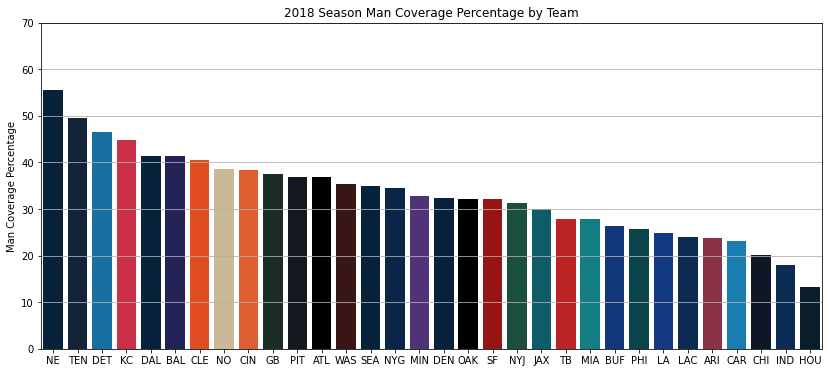

In [79]:
# calculate the man coverage percentage and sort for plotting
team_man_agg = team_df[['defendTeam','man']].groupby('defendTeam').mean().reset_index().sort_values('man', ascending=False)
team_man_agg['man_pct'] = team_man_agg.man * 100

# get team colors into a list format
team_color_dict = {team: colordict['main'] for team, colordict in nflutil.TEAM_COLORS.items()}
team_color_list = [team_color_dict[team].tolist() for team in team_man_agg.defendTeam.tolist()]

# get zone percentages for each team
plt.figure(figsize=(14,6))
plt.grid('on')
sns.barplot(data=team_man_agg, x='defendTeam', y='man_pct',
            palette=team_color_list, ci=None)
plt.ylim([0, 70])
# plt.yticks(np.arange(0,1,0.1));
plt.xlabel('')
plt.ylabel('Man Coverage Percentage')
plt.title('2018 Season Man Coverage Percentage by Team');

In [80]:
print('2018 Man Coverage Percentage by Team (highest to lowest):')
(1 - team_df.groupby('defendTeam')['zone'].mean()).sort_values(ascending=False)

2018 Man Coverage Percentage by Team (highest to lowest):


defendTeam
NE     0.555985
TEN    0.496042
DET    0.464706
KC     0.447552
DAL    0.414097
BAL    0.412776
CLE    0.405745
NO     0.386892
CIN    0.382927
GB     0.375706
PIT    0.369628
ATL    0.368530
WAS    0.353659
SEA    0.348442
NYG    0.344560
MIN    0.328025
DEN    0.323615
OAK    0.322388
SF     0.321543
NYJ    0.312766
JAX    0.300716
TB     0.279570
MIA    0.279018
BUF    0.263959
PHI    0.257426
LA     0.247706
LAC    0.240310
ARI    0.237288
CAR    0.232104
CHI    0.201613
IND    0.180328
HOU    0.132673
Name: zone, dtype: float64

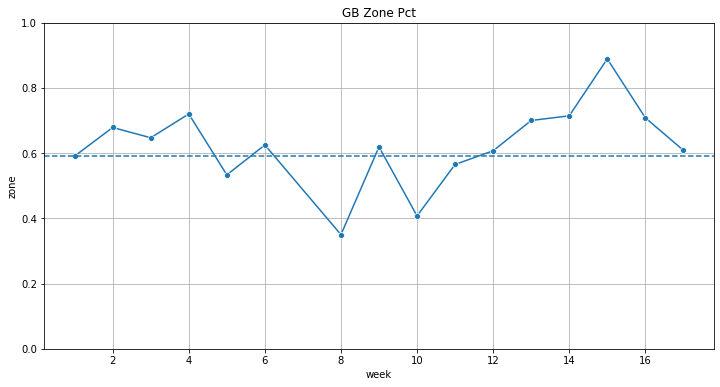

In [81]:
# get zone percentages per week for specific team
team = 'GB'
plt.figure(figsize=(12,6))
sns.lineplot(data=team_df[team_df.defendTeam==team], x='week', y='zone', marker='o', ci=None)
plt.axhline(team_df[(team_df.defendTeam==team) & (team_df.week==1)].zone.mean(), ls='--')
plt.ylim([0,1])
plt.grid('on')
plt.title(f'{team} Zone Pct');

In [82]:
team_df.zone.mean()

0.6703403808666967

In [83]:
team_df[team_df.week==1].zone.mean()

0.6657496561210454

The percentage of zone predicted in weeks 2-17 is effectively the same percentage as labeled in week 1.

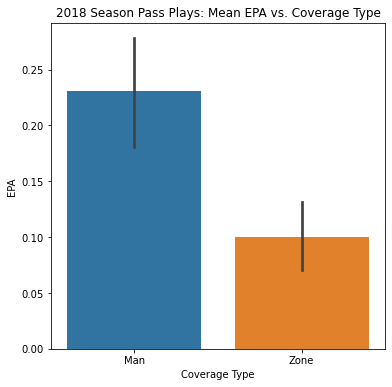

In [84]:
plt.figure(figsize=(6,6))
ax = plt.gcf().gca()
sns.barplot(data=team_df, x='zone', y='epa')
ax.set_xticklabels(['Man','Zone'])
plt.xlabel('Coverage Type')
plt.ylabel('EPA')
plt.title('2018 Season Pass Plays: Mean EPA vs. Coverage Type');

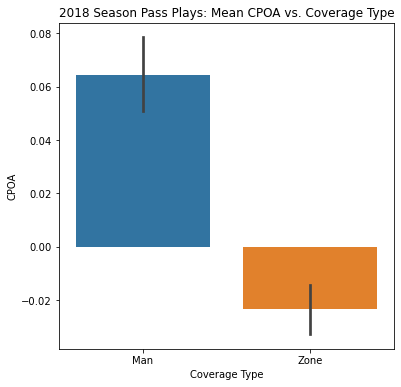

In [85]:
temp = team_df.copy()
temp['cpoa'] = team_df.cp_expect - (team_df.passResult=='C').astype(int)

plt.figure(figsize=(6,6))
ax = plt.gcf().gca()
sns.barplot(data=temp, x='zone', y='cpoa')
ax.set_xticklabels(['Man','Zone'])
plt.xlabel('Coverage Type')
plt.ylabel('CPOA')
plt.title('2018 Season Pass Plays: Mean CPOA vs. Coverage Type');

Man coverages performed worse in terms of EPA, but better in terms of CPOA.

In [86]:
zone_agg = team_df.groupby('zone').agg(
    cp_expect = pd.NamedAgg(column='cp_expect', aggfunc='mean'),
    cp_actual = pd.NamedAgg(column='passResult', aggfunc=lambda x: np.mean(x=='C')),
)

zone_agg['cpoa'] = zone_agg.cp_expect - zone_agg.cp_actual

zone_agg.drop(columns=['cp_expect', 'cp_actual'], inplace=True)
zone_agg = zone_agg.unstack()

zone_agg.columns=['cpoa_man', 'cpoa_zone']

zone_agg

      zone
cpoa  0.0     0.064397
      1.0    -0.023162
dtype: float64

In [87]:
team_agg = team_df.groupby(['defendTeam', 'zone']).agg(
    cp_expect = pd.NamedAgg(column='cp_expect', aggfunc='mean'),
    cp_actual = pd.NamedAgg(column='passResult', aggfunc=lambda x: np.mean(x=='C')),
    epa = pd.NamedAgg(column='epa', aggfunc='mean')
)

team_agg['cpoa'] = team_agg.cp_expect - team_agg.cp_actual

team_agg.drop(columns=['cp_expect', 'cp_actual'], inplace=True)
team_agg = team_agg.unstack()

team_agg.columns=['epa_man', 'epa_zone', 'cpoa_man', 'cpoa_zone']

team_agg

,epa_man,epa_zone,cpoa_man,cpoa_zone
defendTeam,,,,
ARI,0.425247,0.164070,0.042313,-0.024258
ATL,0.397938,0.152910,0.019515,-0.056082
BAL,0.144420,-0.007821,0.109920,0.005576
BUF,0.072352,-0.028022,0.138198,0.002066
CAR,0.347506,0.110914,0.058766,-0.054443
CHI,0.033364,-0.016640,0.127295,0.010365
CIN,0.234868,0.262147,0.002410,-0.035115
CLE,0.112592,0.056060,0.113659,-0.019065
DAL,0.253824,0.148341,0.065137,-0.081777


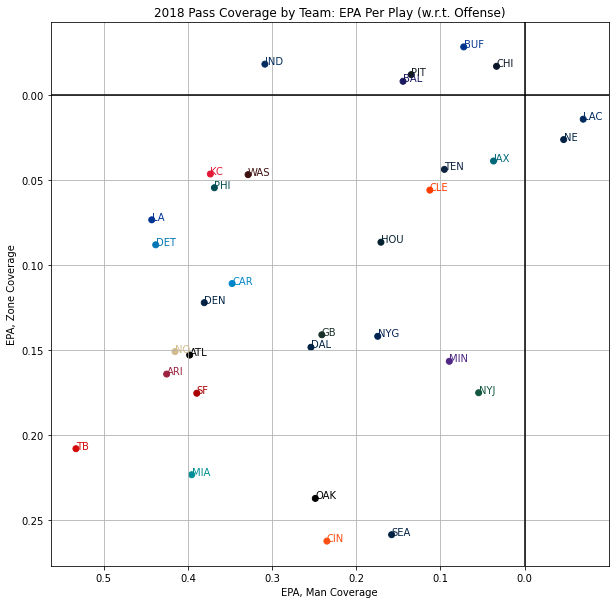

In [88]:
# get team colors into a list format
team_color_dict = {team: colordict['main'] for team, colordict in nflutil.TEAM_COLORS.items()}
team_color_list = [team_color_dict[team].tolist() for team in team_agg.index.tolist()]

# plot EPA for man/zone of each team
plt.figure(figsize=(10,10))
plt.grid('on')
plt.scatter(team_agg.epa_man, team_agg.epa_zone, c=team_color_list)
plt.axhline(0, ls='-', color='k')
plt.axvline(0, ls='-', color='k')

# add the annotations for each team
ax = plt.gcf().gca()
for team, row in team_agg.iterrows():
    ax.annotate(team, (row.epa_man, row.epa_zone), c=team_color_dict[team])

# invert the x and y axes (smaller is better for the defense)
ax.invert_xaxis()
ax.invert_yaxis()

# labels
plt.xlabel('EPA, Man Coverage')
plt.ylabel('EPA, Zone Coverage')
plt.title('2018 Pass Coverage by Team: EPA Per Play (w.r.t. Offense)');

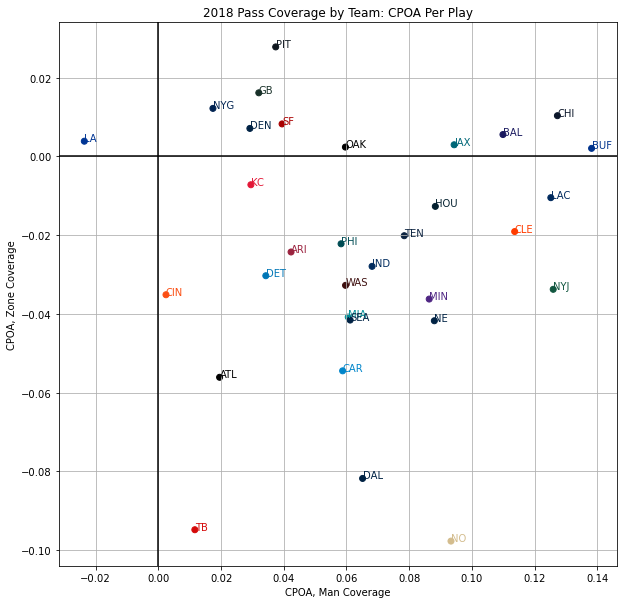

In [89]:
# plot CPOA for man/zone of each team
plt.figure(figsize=(10,10))
plt.grid('on')
plt.scatter(team_agg.cpoa_man, team_agg.cpoa_zone, c=team_color_list)
plt.axhline(0, ls='-', color='k')
plt.axvline(0, ls='-', color='k')

# add the annotations for each team
ax = plt.gcf().gca()
for team, row in team_agg.iterrows():
    ax.annotate(team, (row.cpoa_man, row.cpoa_zone), c=team_color_dict[team])
    
# labels
plt.xlabel('CPOA, Man Coverage')
plt.ylabel('CPOA, Zone Coverage')
plt.title('2018 Pass Coverage by Team: CPOA Per Play');

# Height difference EPA, CPOA and coverage type

In [90]:
target_df

,gameId,playId,targetNflId
0,2018090600,75,2495454.0
1,2018090600,146,2560854.0
2,2018090600,168,2543583.0
3,2018090600,190,2495454.0
4,2018090600,256,2543583.0
...,...,...,...
19234,2018122200,2300,NaN
19235,2018122200,3177,2557870.0
19236,2018122201,566,2540154.0
19237,2018122201,1719,2540154.0


In [91]:
# attach height difference
height_df = pd.merge(cpoa_df.drop(columns='covered'), pass_df[['gameId','playId','tgt_height_adv','tgt_height_adv_bin']],
                     how='left', on=['gameId','playId'])

# attach defender position
height_df = pd.merge(height_df, player_df[['nflId','displayName','position']].copy().rename(
                                                columns={'displayName': 'defenderName', 'position': 'defenderPos'}), 
                   left_on='nflId_def', right_on='nflId', how='left').drop(columns='nflId')

# attach receiver nflId as targetNflId
height_df = pd.merge(height_df, target_df, on=['gameId','playId'], how='left')

# attach receiver position and name
height_df = pd.merge(height_df, player_df[['nflId','displayName','position']].copy().rename(
                                                columns={'displayName': 'receiverName', 'position': 'receiverPos'}), 
                   left_on='targetNflId', right_on='nflId', how='left').drop(columns='nflId')

# add cpoa for each play (for seaborn)
height_df['cpoa'] = height_df.cp_expect - (height_df.passResult=='C').astype(int)

height_df['zone_label'] = 'Man'
height_df.loc[height_df.zone==1, 'zone_label'] = 'Zone'

height_df

,gameId,playId,nflId_def,pass_depth,zone,passResult,epa,cp_expect,tgt_height_adv,tgt_height_adv_bin,defenderName,defenderPos,targetNflId,receiverName,receiverPos,cpoa,zone_label
0,2018090600,75,79848.0,9.00,1.0,C,0.261827,0.643320,3.0,3.0,Malcolm Jenkins,SS,2495454.0,Julio Jones,WR,-0.356680,Zone
1,2018090600,146,2552315.0,4.38,1.0,I,-0.372360,0.737962,0.0,0.0,Jordan Hicks,MLB,2560854.0,Calvin Ridley,WR,0.737962,Zone
2,2018090600,168,2557958.0,-2.85,1.0,I,-0.702779,0.829158,-4.0,-4.0,Sidney Jones,CB,2543583.0,Devonta Freeman,RB,0.829158,Zone
3,2018090600,190,2552689.0,23.14,1.0,C,3.047530,0.373301,4.0,4.0,Ronald Darby,CB,2495454.0,Julio Jones,WR,-0.626699,Zone
4,2018090600,320,2539653.0,3.73,1.0,C,-0.344096,0.749554,2.0,2.0,Robert Alford,CB,2552600.0,Nelson Agholor,WR,-0.250446,Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,2018123014,2170,1302.0,3.84,1.0,I,0.848771,0.747633,0.0,0.0,Aqib Talib,CB,2558914.0,Kendrick Bourne,WR,0.747633,Zone
13334,2018122200,3177,2558136.0,9.42,0.0,I,1.227695,0.634084,-1.0,-1.0,Fabian Moreau,CB,2557870.0,Taywan Taylor,WR,0.634084,Man
13335,2018122201,566,4365.0,25.73,0.0,C,-0.720168,0.340889,2.0,2.0,Brandon Carr,CB,2540154.0,Keenan Allen,WR,-0.659111,Man
13336,2018122201,1719,2540164.0,16.55,0.0,I,1.336078,0.482307,3.0,3.0,Tony Jefferson,SS,2540154.0,Keenan Allen,WR,0.482307,Man


In [139]:
def plot_height_adv_coverage_split(df, target, figsize=(12,6), rec_positions=None, def_positions=None, show_pass_depth=False):
    
    # create label based on target
    if target == 'epa':
        ylabel = 'EPA'
    elif target == 'cpoa':
        ylabel = 'CPOA'
    else:
        ylabel = target
        
    # filter down based on input positions
    plot_df = df.copy()
    if rec_positions:
        if type(rec_positions) is str:
            rp = [rec_positions]  # make it a list
        elif type(rec_positions) is list:
            rp = rec_positions
    else:  # use all positions
        rp = plot_df.receiverPos.unique().tolist()

    if def_positions:
        if type(def_positions) is str:
            dp = [def_positions]  # make it a list
        elif type(def_positions) is list:
            dp = def_positions
    else:  # use all positions
        dp = plot_df.defenderPos.unique().tolist()
    
    
    plot_df = plot_df[plot_df.receiverPos.isin(rp) & plot_df.defenderPos.isin(dp)]
    
    # create custom title based on if positions are input
    title = '2018 Season: ' + ylabel + ' Split by Receiver Height Advantage and Coverage Type'
    if rec_positions or def_positions:
        # starting parentheses
        title += ' ('
    if rec_positions:
        title += ('Receivers: ' + '/'.join(rp))
        if def_positions:
            # add separating comma
            title +=  ', '
    if def_positions:
        title += ('Defenders: ' + '/'.join(dp))
    if rec_positions or def_positions:
        # ending parentheses
        title += ')'
    
    # create plot
    f = plt.figure(figsize=figsize)
    ax1 = f.gca()
    sns.barplot(x=plot_df.tgt_height_adv_bin.astype(int),
                y=plot_df[target],
                hue=plot_df.zone_label,
                hue_order=['Man', 'Zone'],
                ci=None,
                ax=ax1)
    # labels
    plt.xlabel('Receiver Height Advantage (inches, Receiver - Defender)')
    plt.ylabel(ylabel)
    ax1.grid(True, axis='y')

    # add second y-axis for mean pass depth, if desired
    handles, labels = ax1.get_legend_handles_labels()
    
    # if EPA, add mean line
    if target == 'epa':
        sns.lineplot(x=np.arange(len(plot_df.tgt_height_adv_bin.unique())),
                     y=plot_df.groupby('tgt_height_adv_bin')['epa'].mean().to_numpy(),
                     marker='o', linestyle='--', ci=None, color='gray', ax=ax1)
        # add mean EPA line to legend
        line_epa,  = ax1.plot([], [], c='gray', marker='o', linestyle='--', label='Mean EPA')
        handles.append(line_epa)
        labels.append(line_epa.get_label())
        
    
    if show_pass_depth:
        ax2 = ax1.twinx()
        sns.lineplot(x=np.arange(len(plot_df.tgt_height_adv_bin.unique())),
                     y=plot_df.groupby('tgt_height_adv_bin')['pass_depth'].mean().to_numpy(),
                     marker='o', ci=None, color='blue', ax=ax2)
        ax2.set_ylabel('Mean Pass Depth (yds)')
        ax2.tick_params(axis='y', labelcolor='blue')

        # add mean pass depth line to legend
        line_mean_depth,  = ax1.plot([], [], c='blue', marker='o', label='Mean Pass Depth')
        handles.append(line_mean_depth)
        labels.append(line_mean_depth.get_label())
        
    # add legend and title
    ax1.legend(handles, labels)
    plt.title(title)

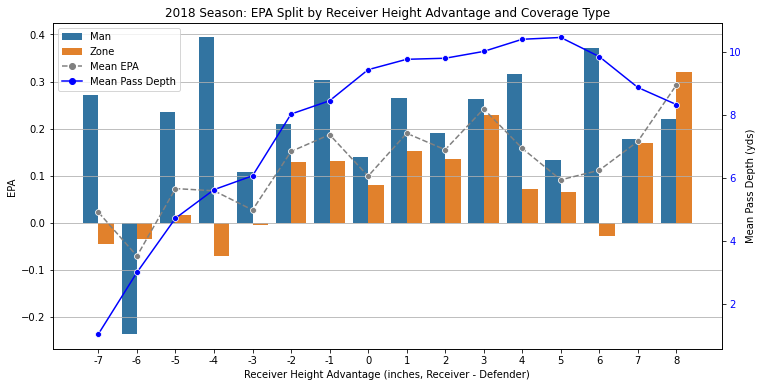

In [141]:
# figsize=(12,6)
# plt.figure(figsize=figsize)
# sns.barplot(data=height_df, x='tgt_height_adv_bin', y='epa', hue='zone_label', hue_order=['Man','Zone'])
# plt.legend(title='Coverage')
# plt.title('2018 Season: EPA Split by Receiver Height Advantage and Coverage Type')
# plt.xlabel('Receiver Height Advantage (in)')
# plt.ylabel('EPA');

plot_height_adv_coverage_split(height_df, 'epa', show_pass_depth=True)

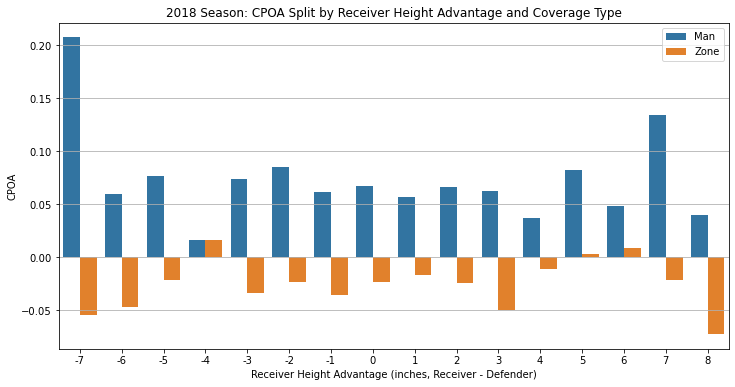

In [142]:
plot_height_adv_coverage_split(height_df, 'cpoa')

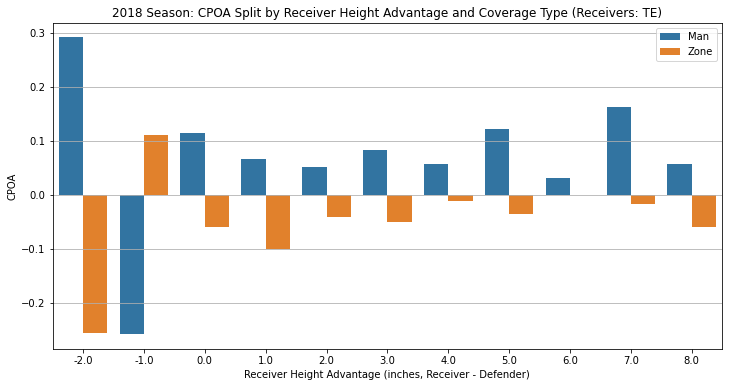

In [95]:
plot_height_adv_coverage_split(height_df, 'cpoa', rec_positions='TE')

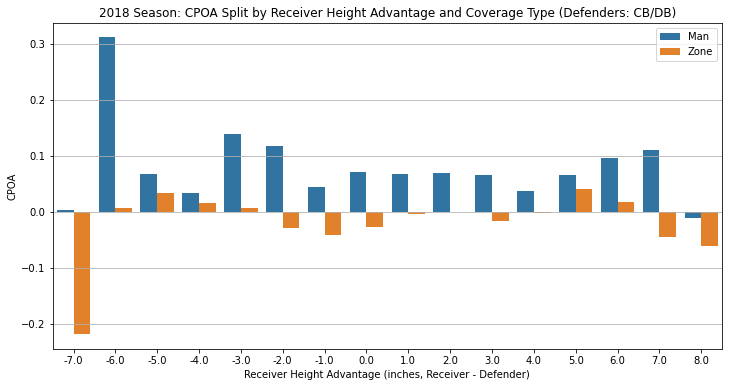

In [96]:
plot_height_adv_coverage_split(height_df, 'cpoa', def_positions=['CB','DB'])

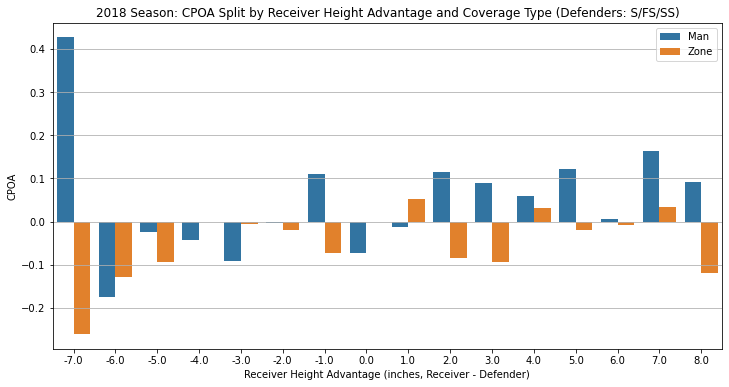

In [97]:
plot_height_adv_coverage_split(height_df, 'cpoa', def_positions=['S','FS','SS'])

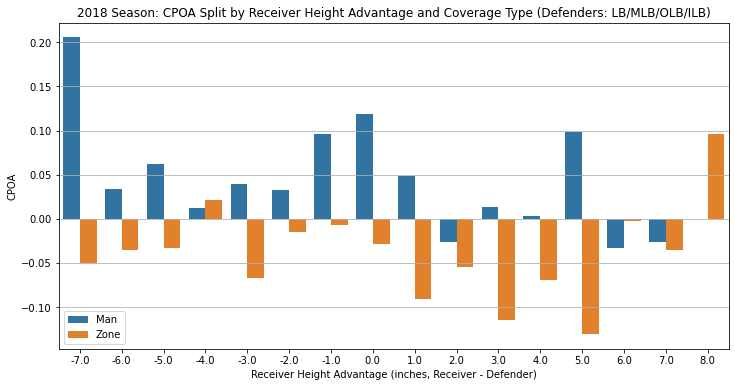

In [98]:
plot_height_adv_coverage_split(height_df, 'cpoa', def_positions=['LB','MLB','OLB','ILB'])

In [99]:
rp = height_df.receiverPos.unique().tolist()
# dp = ['LB','MLB','OLB','ILB']
dp = ['FS','SS','S']

height_df[height_df.receiverPos.isin(rp) & height_df.defenderPos.isin(dp)].groupby('tgt_height_adv_bin').agg('count')['gameId']

tgt_height_adv_bin
-7.0      6
-6.0     33
-5.0     26
-4.0     64
-3.0    104
-2.0    143
-1.0    193
 0.0    212
 1.0    195
 2.0    218
 3.0    228
 4.0    213
 5.0    192
 6.0    163
 7.0    102
 8.0     50
Name: gameId, dtype: int64

# ------- MISC CALCULATIONS ---------------------------

In [100]:
track_df.loc[track_df.event=='pass_outcome_interception', ['gameId','playId','event','frameId']].groupby(['gameId','playId']).head(1)

,gameId,playId,event,frameId
56442,2018090600,3392,pass_outcome_interception,55
57310,2018090600,3481,pass_outcome_interception,58
84718,2018090902,81,pass_outcome_interception,56
92111,2018090902,163,pass_outcome_interception,60
145683,2018090907,584,pass_outcome_interception,57
157449,2018090901,704,pass_outcome_interception,60
172473,2018090905,757,pass_outcome_interception,50
240065,2018090901,1373,pass_outcome_interception,61
260689,2018090901,1516,pass_outcome_interception,78
284534,2018090905,1646,pass_outcome_interception,92


In [101]:
gid = 2018121605
pid = 3489
temp = (track_df.loc[(track_df.gameId==gid) & (track_df.playId==pid), ['gameId','playId','event','frameId']]
 .groupby('frameId').head(1))

temp.loc[temp.event!='None', ['event','frameId']].apply(tuple, 1)

Series([], dtype: float64)

### -------- Play outcome ---------------------------------------------

In [102]:
play_df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa',
       'isDefensivePI'],
      dtype='object')

In [103]:
play_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


In [104]:
play_df[~play_df.penaltyCodes.isna()]

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
25,2018090600,1473,(4:20) M.Ryan pass short left to M.Sanu to PHI...,2,2,9,ATL,play_type_pass,NaN,50,...,3.0,04:20:00,60.0,RPS,PHI 56,C,8,23,1.651961,False
29,2018090600,1680,(1:57) (Shotgun) N.Foles pass short right to N...,2,2,10,PHI,play_type_pass,PHI,5,...,3.0,01:57:00,105.0,RPS,ATL 97,C,4,19,1.299050,False
45,2018090600,2503,(11:04) (Shotgun) M.Ryan pass incomplete short...,3,2,10,ATL,play_type_pass,ATL,32,...,3.0,11:04:00,42.0,ING,ATL 2,I,0,-12,-1.868122,False
91,2018090901,439,(8:05) (Shotgun) B.Roethlisberger pass short r...,1,3,9,PIT,play_type_pass,PIT,43,...,0.0,08:05:00,53.0,IBW,PIT 11,C,0,0,-1.770704,False
92,2018090901,493,(7:39) T.Taylor sacked at CLV 9 for -5 yards (...,1,1,10,CLE,play_type_sack,CLE,14,...,0.0,07:39:00,96.0,UNRd,PIT 90,S,-5,10,1.019909,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,2018122200,2300,(7:53) J.Johnson pass incomplete short left [K...,3,2,5,WAS,play_type_unknown,WAS,31,...,NaN,NaN,NaN,DH,TEN 24,I,0,5,0.848703,False
19235,2018122200,3177,(6:53) (Shotgun) B.Gabbert pass incomplete sho...,4,3,7,TEN,play_type_unknown,WAS,37,...,NaN,NaN,NaN,DH,WAS 31,I,0,5,1.227695,False
19236,2018122201,566,(5:32) (Shotgun) P.Rivers pass deep right to K...,1,3,4,LAC,play_type_unknown,LAC,49,...,NaN,NaN,NaN,OPI,LAC 13,C,27,-10,-0.720168,False
19237,2018122201,1719,(1:08) P.Rivers pass incomplete deep middle to...,2,3,1,LAC,play_type_unknown,LAC,48,...,NaN,NaN,NaN,DPI,BAL 23,I,0,15,1.336078,True


In [105]:
play_df.passResult.value_counts()

C     11370
I      6135
S      1308
IN      420
R         4
Name: passResult, dtype: int64

In [106]:
for _, p in play_df[play_df.penaltyCodes=='DPI'].iterrows():
#     print(p)
    print(f"[{p.gameId}, {p.playId}] {p.playDescription}")
    print()

[2018092700, 1268] (8:13) K.Cousins pass deep right to A.Robinson for 17 yards, TOUCHDOWN. Penalty on LA-S.Shields, Defensive Pass Interference, declined.

[2018100705, 1968] (1:06) (Shotgun) B.Bortles pass deep left to D.Chark to KC 33 for 30 yards (S.Nelson; J.Lucas). Penalty on KC-S.Nelson, Defensive Pass Interference, declined.

[2018101412, 3359] (7:20) (Shotgun) T.Brady pass deep right to C.Hogan to KC 24 for 42 yards (K.Fuller). Penalty on KC-K.Fuller, Defensive Pass Interference, declined.

[2018102800, 2806] (13:10) (Shotgun) C.Wentz pass deep left to J.Matthews to JAX 39 for 36 yards (T.Herndon). Penalty on JAX-T.Herndon, Defensive Pass Interference, declined.

[2018102807, 2870] (5:29) (Shotgun) B.Mayfield pass short left to A.Callaway for 1 yard, TOUCHDOWN. Penalty on PIT-C.Sensabaugh, Defensive Pass Interference, declined.

[2018102806, 785] (1:19) (Shotgun) E.Manning pass deep left to O.Beckham to WAS 38 for 44 yards (G.Stroman). Penalty on WAS-G.Stroman, Defensive Pass I

In [107]:
game_id=2018090900
play_id=742
play_df[(play_df.gameId==game_id) & (play_df.playId == play_id)].iloc[0]

gameId                                                           2018090900
playId                                                                  742
playDescription           (4:50) (No Huddle, Shotgun) J.Flacco pass inco...
quarter                                                                   1
down                                                                      3
yardsToGo                                                                 7
possessionTeam                                                          BAL
playType                                                  play_type_unknown
yardlineSide                                                            BAL
yardlineNumber                                                           37
offenseFormation                                                      EMPTY
personnelO                                                 1 RB, 1 TE, 3 WR
defendersInTheBox                                                         5
numberOfPass

In [108]:
play_df[play_df.playDescription.str.contains("No Play.")].penaltyCodes.value_counts(dropna=False)

DPI           221
DH            187
OPI            77
RPS            57
ICT            36
OH;DH           7
DH;OH           4
OH;RPS          4
DH;DPI          3
ICT;ICT         2
DOF;DPI         2
DPI;OPI         2
OPI;OH          2
DH;OPI          2
DPI;DH          2
OH;DPI          2
DH;ING          1
OPI;DH          1
DH;ICT          1
ICT;DH          1
OPI;IDP         1
ILM;DH          1
DPI;FMM         1
OPI;ILF         1
OPI;UNS         1
DPI;ILH         1
RPS;UNR         1
ICT;TAU         1
DPI;DOF         1
ICT;DPI         1
OH;DH;OH        1
DH;UNSd         1
DH;DOF          1
DOF;RPS         1
RPS;ICT         1
DPI;ICT;DH      1
TAUd;DH         1
DH;DH           1
ICT;OPI         1
NaN             1
Name: penaltyCodes, dtype: int64

### --------------------------------------------------------------

In [109]:
game_df.head()

,gameId,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
0,2018090600,09/06/2018,20:20:00,PHI,ATL,1
1,2018090901,09/09/2018,13:00:00,CLE,PIT,1
2,2018090902,09/09/2018,13:00:00,IND,CIN,1
3,2018090903,09/09/2018,13:00:00,MIA,TEN,1
4,2018090900,09/09/2018,13:00:00,BAL,BUF,1


In [110]:
target_df.head()

,gameId,playId,targetNflId
0,2018090600,75,2495454.0
1,2018090600,146,2560854.0
2,2018090600,168,2543583.0
3,2018090600,190,2495454.0
4,2018090600,256,2543583.0


In [111]:
temp_df = pd.merge(target_df, player_df.rename(columns={'nflId': 'targetNflId'}), how='left', on='targetNflId')
temp_df.head()

,gameId,playId,targetNflId,height,weight,birthDate,collegeName,position,displayName
0,2018090600,75,2495454.0,75.0,220.0,1989-02-08,Alabama,WR,Julio Jones
1,2018090600,146,2560854.0,73.0,190.0,1994-12-20,Alabama,WR,Calvin Ridley
2,2018090600,168,2543583.0,68.0,206.0,1992-03-15,Florida State,RB,Devonta Freeman
3,2018090600,190,2495454.0,75.0,220.0,1989-02-08,Alabama,WR,Julio Jones
4,2018090600,256,2543583.0,68.0,206.0,1992-03-15,Florida State,RB,Devonta Freeman


In [112]:
coverage_df.coverage.value_counts()

Cover 3 Zone    352
Cover 1 Man     296
Cover 4 Zone    152
Cover 2 Zone    113
Cover 6 Zone     69
Cover 2 Man      32
Cover 0 Man      13
Prevent Zone      1
Name: coverage, dtype: int64

In [113]:
track_df.event.value_counts()

None                         908315
ball_snap                     15236
pass_forward                  14166
pass_arrived                  11456
pass_outcome_caught            8179
first_contact                  6866
tackle                         6792
pass_outcome_incomplete        5305
play_action                    2586
out_of_bounds                  1728
line_set                       1489
qb_sack                         788
man_in_motion                   547
pass_outcome_interception       485
touchdown                       366
pass_tipped                     280
fumble                          236
pass_outcome_touchdown          214
qb_strip_sack                   178
fumble_defense_recovered        176
fumble_offense_recovered        149
shift                           132
handoff                         101
penalty_flag                     61
pass_shovel                      60
run                              42
touchback                        30
qb_spike                    

In [114]:
out_df = track_df.groupby(['playId','gameId']).apply(lambda df: np.any(df.event == 'pass_forward') & np.all(df.event != 'pass_arrived')).reset_index()

In [115]:
out_df[out_df[0]]

,playId,gameId,0
1,60,2018091000,True
10,93,2018090912,True
12,96,2018090901,True
13,114,2018090909,True
14,115,2018090912,True
...,...,...,...
1005,4439,2018090600,True
1015,4637,2018090900,True
1027,5233,2018090901,True
1028,5276,2018090901,True


In [116]:
events = []

for pid, gid in zip(out_df[out_df[0]].playId, out_df[out_df[0]].gameId):
    # get events for given play and game ID
    play_events = track_df[(track_df.gameId == gid) & (track_df.playId == pid)].event.unique()
    if np.any(play_events == 'pass_forward'):
        # get index of pass_forward to grab any events that occur afterwards
        idx_pass_fwd = np.where(play_events == 'pass_forward')[0][0]
        if len(play_events)-1 > idx_pass_fwd:
            # get all events after the forward pass event
            after_pass_events = play_events[idx_pass_fwd+1:].tolist()
            if after_pass_events not in events:
                events.append(after_pass_events)
    
events

[['pass_outcome_interception', 'touchdown'],
 ['pass_outcome_incomplete'],
 ['pass_outcome_caught', 'first_contact', 'tackle'],
 ['penalty_flag', 'pass_outcome_incomplete'],
 ['pass_tipped', 'pass_outcome_incomplete'],
 ['pass_outcome_interception', 'first_contact', 'tackle'],
 ['pass_tipped', 'pass_outcome_interception', 'tackle'],
 ['pass_outcome_interception', 'tackle'],
 ['pass_tipped', 'pass_outcome_interception', 'touchdown'],
 ['pass_outcome_incomplete', 'pass_tipped'],
 ['pass_outcome_caught', 'first_contact', 'out_of_bounds'],
 ['fumble_defense_recovered',
  'pass_outcome_interception',
  'first_contact',
  'out_of_bounds']]

In [117]:
game_id = 2018121605
play_id = 1770
track_df[(track_df.gameId == game_id) & (track_df.playId == play_id)].event.unique()

array([], dtype=object)

In [118]:
pass_end_events = ['pass_arrived', 'pass_outcome_interception', 'pass_outcome_incomplete', 'pass_outcome_caught']

In [119]:
PASS_END_EVENTS = ['pass_arrived',
                       'pass_outcome_interception',
                       'pass_outcome_incomplete',
                       'pass_outcome_caught']
PASS_END_EVENTS = ['fake_bad_event']
track_df.loc[track_df.event.isin(PASS_END_EVENTS), 'frameId'].min()

nan

In [120]:
play_df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa',
       'isDefensivePI'],
      dtype='object')

In [121]:
play_df[(play_df.gameId.isin([2018111111, 2018121604])) & (play_df.playId.isin([2502, 1333]))]

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
10835,2018111111,2502,(7:59) (Shotgun) D.Prescott pass incomplete sh...,3,2,8,DAL,play_type_pass,PHI,23,...,6.0,07:59:00,33.0,NaN,NaN,I,0,0,-0.464959,False
15646,2018121604,1333,(10:24) J.Driskel pass incomplete short right ...,2,3,1,CIN,play_type_pass,OAK,1,...,7.0,10:24:00,11.0,NaN,NaN,I,0,0,-0.832880,False


In [122]:
game_df[(game_df.gameId.isin([2018111111, 2018121604]))]

,gameId,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
143,2018111111,11/11/2018,20:20:00,PHI,DAL,10
210,2018121604,12/16/2018,13:00:00,CIN,OAK,15


In [123]:
z=pd.merge(play_df, game_df, on='gameId')
z.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,passResult,offensePlayResult,playResult,epa,isDefensivePI,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,C,10,10,0.261827,False,09/06/2018,20:20:00,PHI,ATL,1
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,I,0,0,-0.372360,False,09/06/2018,20:20:00,PHI,ATL,1
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,I,0,0,-0.702779,False,09/06/2018,20:20:00,PHI,ATL,1
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,C,33,33,3.047530,False,09/06/2018,20:20:00,PHI,ATL,1
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,I,0,0,-0.842272,False,09/06/2018,20:20:00,PHI,ATL,1


In [124]:
z.typeDropback.value_counts()

TRADITIONAL               15645
SCRAMBLE_ROLLOUT_RIGHT     1096
SCRAMBLE                    677
DESIGNED_ROLLOUT_RIGHT      482
SCRAMBLE_ROLLOUT_LEFT       462
DESIGNED_ROLLOUT_LEFT       141
UNKNOWN                      97
Name: typeDropback, dtype: int64

In [125]:
cover_plays = pd.merge(coverage_df, track_df.groupby(['gameId','playId']).head(1)[['gameId','playId']],
        on=['gameId','playId'], how='inner')[['gameId','playId']]

non_unknown_plays = play_df[play_df.typeDropback!='UNKNOWN']

remaining_plays = pd.merge(cover_plays, non_unknown_plays, on=['gameId','playId'], how='inner')

remaining_plays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028 entries, 0 to 1027
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  1028 non-null   int64  
 1   playId                  1028 non-null   int64  
 2   playDescription         1028 non-null   object 
 3   quarter                 1028 non-null   int64  
 4   down                    1028 non-null   int64  
 5   yardsToGo               1028 non-null   int64  
 6   possessionTeam          1028 non-null   object 
 7   playType                1028 non-null   object 
 8   yardlineSide            1013 non-null   object 
 9   yardlineNumber          1028 non-null   int64  
 10  offenseFormation        1025 non-null   object 
 11  personnelO              1027 non-null   object 
 12  defendersInTheBox       1025 non-null   float64
 13  numberOfPassRushers     986 non-null    float64
 14  personnelD              1027 non-null   

In [126]:
for desc in z[(z.week==1) & (z.typeDropback=='UNKNOWN')]['playDescription']:
    print(desc)

(:14) (No Huddle) T.Taylor spiked the ball to stop the clock.
(:08) C.Newton spiked the ball to stop the clock.
